# Week 7: Regression Trees and Advaced Regression Methods

This week we will study:
- Tree based models: CART, Random Forests and E<b>x</b>treme <b>G</b>radient <b>B</b>oosting
- General procedures concerning imbalanced datasets
- Various advanced topic regression methods

# Classification and Regression Trees

# Overview

Based on and contains excerpts from [<i>Classification and Regression Trees,
Bagging, and Boosting</i>](http://mason.gmu.edu/~csutton/vt6.pdf) and [<i>Machine Learning and Data Mining</i>](https://nemor.cz/data/mac.pdf).

Tree-structured classification and regression are alternative approaches to classification and regression that are not based on assumptions of normality and user-specified model statements. Usually, the resulting tree-structured predictors can be relatively simple functions of the input variables which are easy to use. For domain experts it is usually interesting to review the tree structure because it often conforms to their knowledge of the problem or even provides new insights. Tree-based models are often regarded as a [symbolic learning](https://en.wikipedia.org/wiki/Symbolic_artificial_intelligence) model, in which the problem is approached from a high-level "symbolic" representations of problems, logic and search. 

In the 1980s, statisticians Breiman et al. (1984) developed CART (Classification And Regression Trees), which is a sophisticated program for fitting trees to data. Since then there have been numerous improvements building on the CART framework, e.g. `rpart` in R (Or the Python scikit. Note that rpart allows post pruning but sklearn does not, [leading to overfittings for the latter](https://datascience.stackexchange.com/questions/31424/r-vs-python-decision-tree)). Essentially, building a regression (resp. classification if $y$ is binary) tree can be described as the following greedy process. The process is greedy because the process of looking for the best attribute to split (and how to split) depend only on current information.

<img src="https://github.com/kpjwong/ISYE-6501/blob/main/images/CART_alg.PNG?raw=true" width="60%">

Or the following pseudocode,

```python
class node:
    def __init__(self, data, attr=None, F=None, children=None):
        self.data = data
        self.attr = None
        self.F = F # could be y_data.mean(), a regression, etc.
        self.children = children

# each subtree is a list of node
def grow_tree(node):
    if is_leaf(node):
        node.F = find_bestrule(node.data)
        return [node]
    node.attr = find_bestattr(node.data) # could be more than one
    node.children = find_split(node.data, node.attr) # cache-aware
    return [node] + [grow_tree(next_node) for next_node in node.children]

# grow tree from root
root = node(data)
grow_tree(root)
```

Alternatively, the regression tree can be considered a mapping from data vector $X_i \in \mathbb{R}^k$ according to the value of its $k$ attributes to a leaf node $q$ (terminal node) where the target variable $y$ is predicted as $\hat{y}_i = f^q(X_i)$. Usually, $f^q$ is a constant $w^q$, but it could be arbitrary, like a linear regression function $\beta^q X_i$. The mapping from $X$ to $q$ does not necessarily have a closed form: as we have seen, it could involve sequential partition involving the same dimension $X^k$. 

The stopping criterion (`is_leaf`) is usually determined when either, the learning set is pure enough (e.g., all examples or most of them are labelled with the same class label), there are not enough learning examples, or there are no good attributes left. Another key factor of a decision tree building algorithm is the choice of the best attribute (`find_bestattr`). For this purpose, impurity measures such as [information gain](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees), information gain ratio, [Gini-index](https://medium.com/@analyttica/gini-coefficient-or-gini-index-in-our-data-science-analytics-platform-d0408fc83772), and [ReliefF](https://en.wikipedia.org/wiki/Relief_(feature_selection)) are frequently used. 

Since the reliability of class probability estimations in decision tree leaves is highly dependent on the number of learning examples, it is not advisable to shatter the learning set into too small subsets of examples. Many learning algorithms build binary decision trees by binarizing the attributes prior to quality estimation, so `find_split` essentially collapses to a binary rule, such as `node.left`, `node.right` in the conventional binary tree operation. Binary attributes in decision trees allow for using attribute quality measures that otherwise over-estimate multi-valued attributes, such as information gain and
Gini-index. Binary decision trees are usually smaller than the ordinary ones, thus providing better generalization and better performance (e.g., classification accuracy). 

# Algorithm and Model Selection

## Metrics for Splitting Criterion

There are various algorithms to grow and find the best tree. Notable ones include: the original CART, Iterative Dichotomiser 3 (ID3) and its successor C4.5, Chi-square automatic interaction detection (CHAID), and MARS. We won't be able to go over the details of them, but we will go through important elements of regression tree algorithms in general - metrics and post-pruning. To measure the quality of a split in choosing best attribute and best split for the chosen attribute, several criteria are used. Notice that they correspond to impurity measures, as the notion of classification errors within the training set is not really defined in the tree growing process. The examples included feature discrete predictor attributes, if the attribute is continuous, one can discretize the attribute by [splitting on each observed value](https://www.youtube.com/watch?v=OD8aO4ovIBo), while [started with median values](https://datascience.stackexchange.com/questions/22771/should-we-use-discrete-or-continuous-input-for-decision-trees) is usually a good way to start. 

## Gini Impurity

Gini-impurity is used in the original CART algorithm. It is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. The Gini impurity can be computed by summing the probability $p_i$ of an item with label $i$ being chosen times the probability $1-p_i$ of a mistake in categorizing that item. It reaches its minimum (zero) when all cases in the node fall into a single target category:

\begin{align*}
G(p) = \sum_i^J p_i \big( \sum_{k \neq i} p_k \big) = \sum_{i=1}^J p_i(1-p_i) = 1 - \sum_{i=1}^J p_i^2
\end{align*}

### Gini Impurity for a node split

Now we apply the concept of Gini impurity to a split according to a data attribute in a classification tree. The Gini impurity for a split according to attribute $m$ resulting in $K$ nodes (for continuous variables, it should be a binary split), each node with distribution of classes $p_k$ over the $J$ distinct classes of the label variable is given by:

\begin{align*}
G = \sum_{k=1}^K \frac{n_k}{n} G(p_k) = \sum_{k=1}^K \frac{n_k}{n} \big( 1 - \sum_{i=1}^J p_k(i)^2 \big)
\end{align*}

For example, consider the following split of a classification tree with target lable `Rain` in the `humidity` dimension, resulting in 2 nodes. 

| Humidity | Rain=1 | Rain=0 | Instances |
|:--------:|:---:|:--:|:---------:|
| High     | 1   | 1  | 2         |
| Normal   | 2   | 1  | 3         |

The resulting Gini-impurity resulting from splitting the sample in the `humidity` dimension is given by:

\begin{align*}
\frac{2}{5} \bigg[ 1-\Big(\frac{1}{2}\Big)^2-\Big(\frac{1}{2}\Big)^2 \bigg] + \frac{3}{5} \bigg[ 1-\Big(\frac{2}{3}\Big)^2-\Big(\frac{1}{3}\Big)^2 \bigg] = 0.466
\end{align*}

At a node, we compute the Gini impurity for splits using each attribute to decide which attribute to split (`find_bestattr`). A stopping criteria could be an upper bound of $G$ - stop tree growing and make node a leaf if the sample is sufficiently pure.


## Entropy

The entropy a node $T$ is the average level of "information", "surprise", or "uncertainty" inherent in the variable's possible outcomes, and is defined by:

\begin{align*}
H(T) = -\sum_{i=1}^J p_i \log_2 p_i
\end{align*}

### Information Gain for a node split

Another way for growing tree is the maximize information gain approach. The information gain for a node split according to attribute $a$ is defined as the decrease in entrpy from the current node to the expected entropy across the children node:

\begin{align*}
IG(T,a) = H(T) - H(T|a) = H(T) - \sum_i p_{i,a} H(i)
\end{align*}

Using the above example, the entropy of the original node is: $-0.6\log_2 0.6 - 0.4 \log_2 0.4 = 1.06$. The expected entropy of the children nodes resulting from the split is: $0.4 \times (-\frac{1}{2}\log_2 \frac{1}{2} - \frac{1}{2}\log_2 \frac{1}{2}) + 0.6 \times (-\frac{1}{3}\log_2 \frac{1}{3} - \frac{2}{3}\log_2 \frac{2}{3}) = 0.91$. So the information gain is 0.15. 

A stopping criteria is usually lower bound of $IG$ - if splitting on any attribute will not improve information content above a threshold, the growing process should stop and make the current node a leaf.

## Variance

When the target variabe $y$ is continuous, we can consider the a variance reduction in which the variance of a node is defined as $Var(y|T)$ for all samples of $y$ in node $T$. A more general form is to have in place a prediction rule given $X$ (`find_bestrule`) for children node $i$, $h^i(X)$ and consider the sum of squared errors (error variance/MSE). We refer to the value assignment at leave $c$ as $m_c$. The variance (MSE) for __regression tree__ (as per [Shalizi](http://www.stat.cmu.edu/~cshalizi/350/lectures/22/lecture-22.pdf)) is:

\begin{align*}
S = \sum_{c \in leaf} \sum_{i \in c} (y_i -m_c)^2 = \sum_{c \in leaf} n_c V_c
\end{align*}

To train a regression tree:
1. Start with a single node containing all points. Calculate $m_c$ and $S$
2. If all the points in the node have the same value for all the input variables, stop. Otherwise, search over all binary splits of all variables for the one which will reduce $S$ as much as possible. If the largest decrease in $S$ would be less than some threshold $\delta$, or one of the resulting nodes would contain less than $q$ points, stop. Otherwise, take that split, creating two new nodes.
3. In each new node, go back to step 1.


## Pruning

It is well-noted in the literature that CART is prone to overfitting and becoming too familiar with the training data. It is recommended that the practitioner uses mechanisms to stop the tree growing process before it overfits the data. Such mechanisms are referred as pruning of decision trees. 

### Pre-pruning

Here are [some pruning methods](https://sebastianraschka.com/pdf/lecture-notes/stat479fs18/06_trees_notes.pdf) that can be applied prior to training a decision tree. 

- Set a minimum number of data points for each node.
- Max depth: Set a depth cut-off (maximum tree depth) a priori. Check [here](https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6) for an example of using CV to find best depth.
- [Chi-square pruning](https://www.cs.cmu.edu/afs/cs.cmu.edu/academic/class/15381-s06/www/DTs2.pdf): stop growing if a split is not statistically significant (e.g., $\chi^2$ test)

### Post-pruning

On top of the pre-pruning methods above, one may also be motivated to post-prune a decision tree after it is trained - i.e. converting some inefficient subtrees (internal node) into single leaf (terminal) nodes. In general, a post-pruning algorithm can be expressed as:

<img src="https://github.com/kpjwong/ISYE-6501/blob/main/images/Post_prune_alg.PNG?raw=true" width="60%">

A basic form of post-pruning is [reduced-error pruning](https://sebastianraschka.com/pdf/lecture-notes/stat479fs18/06_trees_notes.pdf), which we greedily remove nodes based on validation set performance; it
generally improves performance but can be problematic for limited data set sizes

Cost-complexity pruning is a common way to prune a decision tree after training. The idea is to add a regularization term to the impurity measure $I$ after training the unregularized model $\alpha=0$, such that the new objective function becomes $I + \alpha |N|$, where $\alpha$ is a tuning parameter and $|N|$ is the total number of nodes. Check [this Statquest video](https://www.youtube.com/watch?v=D0efHEJsfHo) for details and [this page](https://statinfer.com/203-3-10-pruning-a-decision-tree-in-r/) for an R implementation example. For each $\alpha$, we compute the error of each subtree into a leaf node, from a botton-up manner and then tranform subtree that are penalized to leaf nodes, now that $\alpha$ is added to the impurity meausre. As $\alpha$ increases, we expect to have smaller trees. The optimal depth with $\alpha$ is then selected using CV.

## Splitting Data

An excerpt from [this Ecological Informatics article](https://sebastianraschka.com/pdf/lecture-notes/stat479fs18/06_trees_notes.pdf). 

### The need for an independent test set

If the sample size is sufficiently large, the data can be divided into two subsets randomly, namely, one for training and other for testing. Defining sufficiently large is problem specific, but one rule of thumb in classification problems is to allow a minimum of 200 observations for a binary classification model, with an additional 100 observations for each additional class. An overly large tree is grown on the training data. Then, using the test set, error rates are calculated for the full tree as well as all smaller subtrees (i.e., trees having fewer terminal nodes than the full tree). Error rates for classification trees are typically the overall misclassification rate, while for regression problems, mean squared error or mean absolute deviation
from the median are the criteria used to rank trees of different size. The subtree with the smallest error rate based on the independent test set is then chosen as the optimal tree.

Questions often arise as to whether one should use an independent test set or cross-validated estimates of error rates. One thing to consider is that cross-validated error rates are based on models built with only 90% of the data. Consequently, they will not be as good as a model built with all of the data and will consistently result in slightly higher error rates, providing the modeler a conservative independent estimate of error. However, in regression tree applications in particular, this overestimate of error can be substantially higher than the truth, giving more incentive to the modeler to find an  independent test set.

### The need for an independent pruning set

If the sample size is not large, it is necessary to retain all the data for training purposes. However, pruning and testing must be done using independent data. A way around the dilemma is through $k$-fold cross-validation. Here, all the data are used to fit an initial overly large tree. The data is then divided into (usually) $k$ = 10 subgroups, and 10 separate models fit. The first model uses subgroups 1–9 for training, and subgroup 10 for testing. The second model uses groups 1–8 and 10 for training, and group 9 for testing, and so on. In all cases, an independent test subgroup is available. These 10 test subgroups are then combined to give independent error rates for the initial overly large tree which was fit using all the data. Pruning of this initial tree proceeds as it did in the case of the independent test set, where error rates are calculated for the full tree as well as all smaller subtrees. The subtree with the smallest error rate based on the independent test set is then chosen as the optimal tree.

# Pros/Cons and Applications

__Pros__: 
- Easy to [interpret](https://christophm.github.io/interpretable-ml-book/tree.html) and communicate
- Independent of feature scaling

__Cons__: 
- Easy to overfit and sensitive to outliers
- Elaborate pruning required
- Output range is bounded (dep. on training examples) in regression trees
- Expensive to just fit a "diagonal line" (e.g. figure below from)

<img src="https://raw.githubusercontent.com/alexeygrigorev/wiki-figures/master/ufrt/kddm/decision-tree-boundary.png">

__Applications__: Check [MIT's courseware](https://ocw.mit.edu/courses/sloan-school-of-management/15-071-the-analytics-edge-spring-2017/trees/) for various application of CART including prediction of court's judgement, healthcare costs, and house prices using just latitudes and longitudes (figure below).

<img src="https://github.com/kpjwong/ISYE-6501/blob/main/images/CA_house_price.PNG?raw=true" width="40%">

# Random Forest

## Motivation: Why Bagging Works

## Algorithm and Model Selection

## Interpretation

## Example (if any)

## Pros and Cons

# Background: Gradient Boosting & Stochastic Gradient Boosting

Mainly based on [Hastings text book](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) and various online sources. The term "Boosting" refers to a family of algorithms which converts weak learner to strong learners. Boosting is an ensemble method for improving the model predictions of any given learning algorithm. The idea of boosting is to train weak learners sequentially, each trying to correct its predecessor.


# Gradient Boosting Machine

## Overview

Based on [Friedman (1999)](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf). We consider the following optimization problem in a supervised learning setting:

\begin{align*}
F^* &= \arg \min_{F} E_{y,X} \big[ L(y,F(X)) \big] = \arg \min_{F} E_X \big[ E_y[ L(y,F(X)) | X ]  \big]
\end{align*}

Here $L$ is a loss function (e.g. log-likelihood, sum of squared errors). Note that without a parameterization, we are optimization over the function space $\{F: \mathbb{R}^{|X|} \rightarrow \mathbb{R}\}$. We are interested in the functional subspace $\mathcal{F} = \big\{F: F(x;\{\beta_m, a_m\}_{m=1}^M) = \sum_{m=1}^M \beta_m h(x;a_m) \big\}$. The basis function $h$ is also known as the base learner. We will see later how regression trees fit naturally into this criteria. 

Now the optimization is essentially parameteric:

\begin{align*}
\{ \beta^*_m, a^*_m \} &= \arg \min_{\{\beta_m, a_m\}} E_{y,X} \big[ L\big(y,\sum_{m=1}^M \beta_m h(X;a_m)\big) \big]
\end{align*}

With with finite data, we consider the data based estimate of expected loss:

\begin{align*}
\{ \beta^*_m, a^*_m \} &= \arg \min_{\{\beta_m, a_m\}} \sum_{i=1}^N L\big(y_i,\sum_{m=1}^M \beta_m h(X_i;a_m)\big)
\end{align*}


When joint optimization is not possible, one may try the following <i>greedy stage-wise</i> approach. First we break down $F^*$ into $m$ additive approximators $F_m$:


\begin{align*}
F^*(X) &= \sum_{m=1}^M \beta^*_m h(X_i;a^*_m) \triangleq \sum_{m=1}^M F_m(X) \\
\end{align*}

Then we consider the following __boosting__ equations:

\begin{align*}
(\beta^*_m, a^*_m) &= \arg \min_{\beta_m, a_m} \sum_{i=1}^N L\big(y_i, F_{m-1}(X_i) + \beta_m h(X_i;a_m)\big) \\
F_m(X) &= F_{m-1}(X_i) + \beta^*_m h(X_i;a^*_m)\\
\end{align*}

Given any approxmiator $F_{m-1}(X)$, the function $\beta_m h(X; a_m)$ can be viewed as the best greedy step towards the optimal solution $F^*(X)$. Equivalently, we know that $\beta_m h(X; a_m)$ must point towards to the opposite direction of the steepest descent, i.e. parallel to $-g_m = \{-g_m(X_i)\}_1^N$, with:

\begin{align*}
-g_m(X_i) = -\bigg[ \frac{\partial L(y_i, F(X_i))}{\partial F(X_i)} \bigg]_{F(X_i)=F_{n-1}(X_i)}
\end{align*}

Note that $g_m$ is only defined on $\{X_i\}_{i=1}^N$, we using the smoothness of $h$ to extend the domain. Since $\beta_m$ is a scalar, the direction of $\beta_m h(X; a_m)$ should depend on $a_m$ only. A criterion for $a_m$ is therefore,

\begin{align*}
a^*_m = \arg \min_{a,\delta} \sum_{i=1}^N \big[ -g_m(X_i) - \delta h(X_i; a) \big]^2
\end{align*}

Here $\delta$ is a nuisance parameter. Now that $h(X; a^*_m)$ points to the steepest descent, it suffice for us to find $\beta^*_m$, the optimal step size. Here we use the [linear search](https://www.cs.cmu.edu/~ggordon/10725-F12/scribes/10725_Lecture5.pdf) approach $\arg \min_{s \geq 0} f(x-s\nabla f(x))$:

\begin{align*}
\beta^*_m = \arg \min_{\beta} \sum_{i=1}^N L\big(y_i, F_{m-1}(X_i) + \beta h(X_i, a_m^*)\big)
\end{align*}

### Summary of Algorithm
- Use additive finite Series to approximate the optimal function, each of the $M$ approximator is a basis learner $h$
- Use a stagewise greedy optimization to approximate joint optimization of the series param/coeff
- Param of basis is chosen such that the basis points to the direction of negative gradient, i.e. steepest descent
- Coeff of basis is chosen using line search step size
- Resulting pseudocode, with a slight change of parameter naming, is illustrated as follows:

<img src="https://i.stack.imgur.com/E3HVG.png">

## Gradient Boosting Trees

Ensemble regression trees fits in the class overall approximation function $F$ that can be naturally decomposed into additive approximators. When each base learner $h$ is a regression tree with $J$ leaf and using single score $b_j$ for each leaf $R_j$, we can consider the value assignment $\{b_j\}_{j=1}^J$ and nodes $\{R_j\}_{j=1}^J$ as the coefficients and parameters for the tree represented by $h$. Formally,

\begin{align*}
h(X; \{b_j, R_j\}_{j=1}^J) = \sum_{j=1}^J b_j I\{X \in R_j\}
\end{align*}

So essentially, these base learner trees form an ensemble regression tree that defines $F$. Each regression tree has the previous error as target. To see this, note that the additive modeling problem can be expressed as:

\begin{align*}
\text{Tree}_m(X) = \arg \min_{\text{Tree}} \sum_{i=1}^N L\big( y_i, F_{m-1}(X) + \text{Tree} (X) \big) 
\end{align*}

The multiplicative coefficient to the base learners ($\beta_m$) are natrually absorbed by the tree. Since we would like to minimize the overall loss, we will be training a regression fitting the gradient of $L$ with respect to $F$, evaluated at $F_{m-1}$. For example, if $L$ is the sum of squared loss, the gradient will be previous residuals and if $L$ is the absolute deviation this term is just the sign of the previous residuals. An advantage offered by the structure of the regression tree learner function is that each tree can be considered an additive model as $h = \sum_{j=1}^J b_j I\{X \in R_j\}$. Given nodes $\{R_{jm}\}$ for tree $m$,

\begin{align*}
\{b_{jm}^*\}_{j=1}^{J_m} &= \arg \min_{\{b_j\}} \sum_{i=1}^N L\big( y_i, F_{m-1}(X_i) + \sum_{j=1}^{J_m} b_j I\{ X_i \in R_{jm} \} \big) & &\\
b^*_{jm} &= \arg \min_{b_j} \sum_{i:X_i\in R_{jm}} L\big( y_i, F_{m-1}(X_i)-b_j \big) & &\because R_{jm} \text{ are disjoint} 
\end{align*}

The decomposition in the second line is implied by the disjoint nature of regions produced by regression trees. To sum up, the pseudocode, upon parameter renaming is:

<img src="https://miro.medium.com/max/2160/1*xQXPUxSnBd1lOxjLoePoVQ.png" width="50%">

## Regularization and Model Selection

### Shrinkage

Ways to control for overfitting for boosting trees include controlling the maximum depth $\bar{J} = \max_m J_m$ and the number of boosting approximators $M$ (note that $M$ is also the number of iterations implied by an accuracy threshold, or "training risk": trees are added continuously until the prediction is smaller than $\varepsilon$). On top of these, it is recommended that the gradient update $\beta_m^* h(X; a_m^*)$ be shrunken by multiplying to a small constant $\nu \in (0,1)$ to avoid overfitting the data. The parameter $\nu$ can be regarded as controlling the learning rate of the boosting procedure. Smaller values of ν (more shrinkage) result in larger training risk for the same number of iterations M. Thus, both $\nu$ and $M$ control prediction risk on the training data. Note that these parameters do not operate independently. Smaller values of $\nu$ lead to larger values of $M$ for the same training risk, so that there is a tradeoff between them.

Empirically it has been found (Friedman, 2001) that smaller values of $\nu$ favor better test error, and require correspondingly larger values of $M$. In fact, the best strategy appears to be to set $\nu$ to be very small ($\nu < 0.1$) and then choose $M$ by early stopping. This yields dramatic improvements (over no shrinkage $\nu$ = 1) for regression and for probability estimation. The corresponding improvements in misclassification risk via (10.20) are less, but still substantial. The price paid for these improvements is computational: smaller values of $\nu$ give rise to larger values of $M$, and computation is proportional to the latter. However, many iterations are generally computationally feasible even on very large data sets. This is partly due to the fact that small trees are induced at each step with no pruning.

### Stochastic Boosting

With [stochastic gradient boosting (Friedman, 1999)](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf), at each iteration we
sample a fraction $\eta$ of the training observations (without replacement), and grow the next tree using that subsample. The rest of the algorithm is identical. A typical value for $\eta$ can be 1/2, although for large $N$, $\eta$ can be substantially smaller than half. Not only does the sampling reduce the computing time by the same fraction $\eta$, but in many cases it actually produces a more accurate model. 

<img src="https://www.researchgate.net/profile/Msi-Malik/publication/320363849/figure/fig2/AS:553306791608320@1508930027595/Stochastic-gradient-boosting-Friedman-2002.png" width="50%">

Simulation studies showed that subsampling without shrinkage does poorly, so have four parameters to set: $J$ (size of trees), $M$ (number of iterations/additive trees), $\nu$ (regularization) and $\eta$ (subsample). Typically some early explorations determine suitable values for $J$, $\nu$ and $\eta$, leaving $M$ as the primary parameter.

## Interpretation

Single decision trees are highly interpretable. The entire model can be completely represented by a simple two-dimensional graphic (binary tree) that is easily visualized. Linear combinations of trees lose this important feature, and must therefore be interpreted in a different way. 

### Relative Importance

Often in regression trees, only a few of the features have substantial influence on the response; the vast majority are irrelevant and could just as well have not been included. It is often useful to learn the relative importance or contribution of each input variable in predicting the response. As an extension of the suggestion by Breiman (1984), the relative importance of feature $l$ for each tree $T$ and the additive tree expansions are:

\begin{align*}
I_l^2(T_m) &= \sum_{t=1}^{J_m-1} \hat{\iota}_t^2 I(\nu(t) = l) \\
I_l^2 &= \frac{1}{M} \sum_{m=1}^M I_l^2(T_m)
\end{align*}

In the first equation, $t$ is the index for internal nodes (note that if there are $J$ terminal nodes, there will be $J-1$ internal nodes). $\hat{\iota}$ is the gain in criterion (e.g. information gain, gini index, R sqaured) and $\nu(t)$ is the feature being splitted at $t$.

The feature importance is aggregated by averaging for the additive tree expansion. Due to the stabilizing effect of averaging, $I_l^2$ is more reliable than $I_l^2(T_m)$ for a single tree $m$. With shrinkage $\nu$, the masking of important variables by others with which they are highly correlated will become less of a problem. Note that here $I_l^2$ and $I_l^2(T_m)$ are squared relevance; the actual relevances are their respective square roots. Since these measures are relative, it is customary to assign the largest a value of 100 and then scale the others accordingly. 

### Partial Dependence Plots

For low dimensional models, graphical renderings of the $f(X)$ as a function of its arguments provides a comprehensive summary of its dependence on the joint values of the input variables. For more than two or three variables, viewing functions of the corresponding higher-dimensional arguments is more difficult. A useful alternative can sometimes be to view a collection of plots, each one of which shows the partial dependence of the approximation $f(X)$ on __a selected small subset__ of the input variables. Although such a collection can seldom provide a comprehensive depiction of the approximation, it can often produce helpful clues, especially when $f(X)$ is dominated by low-order interactions (e.g. 1st, 2nd order interactions).

Formally, let $X_S$ be a set of selected features and $X_C$ be the set of compliments such that $X_S \cup X_C = \{X_1, \ldots, X_p\}$ the feature space. With $\{X_{C1}, \ldots, X_{CN}\}$ the set of values of $X_C$ in the training data and $g()$ their joint distribution, the theoretical and data-based partial effect for $X_S$ is defined as:

\begin{align*}
f_S(X_S) &= E_{X_C}\big[ f(X_S, X_C) \big] =\int f(X_S,X_C) g_{X_C}(X_C) dX_C \\
\bar{f}_(X_S) &= \frac{1}{N} \sum_{i=1}^N f(X_S,X_{Ci})
\end{align*}

Note that $f_S(X_S)$ is the effect of $X_S$ on $f(X)$ after accounting for the (average) effects of the other variables $X_C$ on $f(X)$. This is not to be confused with $\hat{f}_S(X_S)$, the the effect of $X_S$ on $f(X)$ ignoring the effects of $X_C$. 

\begin{align*}
\hat{f}_S(X_S) &= E\big[ f(X_S, X_C) | X_S\big] =\int f(X_S,X_C) g_{X_C|X_S}(X_C|X_S) dX_C \\
\end{align*}

The conditional mean $\hat{f}_S(X_S)$ should equate the marginal mean $f_S(X_S)$ only when $X_S$ and $X_C$ are independent.

# AdaBoost

Based on [Freund and Schapire (1997)](https://www.face-rec.org/algorithms/Boosting-Ensemble/decision-theoretic_generalization.pdf) and [Hastings text book](https://web.stanford.edu/~hastie/Papers/ESLII.pdf).

## Overview

AdaBoost, short for Adaptive Boosting, is a machine learning meta-algorithm formulated by Yoav Freund and Robert Schapire. In this PAC (see below) framework, a training sample with $N$ observations are passed to the learner, which outputs a guess of the target rule after $T$ periods. The authors developed a generalization of Littlestone and Warmuth's "weighted majority" (voting) algorithm in which wrong decisions are discounted among a pool of learners to a dynamic allocation problem. Formally, each iteration/trial $t$ is assigned a weight vector according an error penalty scheme and at the end, the output rule is a weighted average across the $T$ trials. It was shown that the average per trial net loss for adaboost is bounded by $O\sqrt{\frac{\ln N}{T}}$.

## Preliminary

In their [1997 paper](https://www.face-rec.org/algorithms/Boosting-Ensemble/decision-theoretic_generalization.pdf), Freund and Schapire proposed an <b>online allocation model</b> under the <b>Probably Approximately Correct</b> (PAC) learning framework. In this framework, denote $X$ the domain and a functional subspace $c: X \rightarrow \{0,1\}$ the concept class. The learner is given a set of training examples $\{(x_i, c^*(x_i)\}_{i=1}^N$ where $\{x_i\}_{i=1}^N$ were randomly chosen from a fixed distribution $\mathcal{D}$ on $X$. $c^*$ is the target concept that the learner aims to infer. After some period $T$, the learner must form hypothesis $h: X \rightarrow [0,1]$ (could arise of aggregated hypotheses $h_t$ each period). Note that the support for $h$ is continuous, and the value $h(x)$ can be interpreted as a randomized prediction of the label of $x$ that is 1 with probability $h(x)$ and 0 with probability $1-h(x)$. Note that a learner output $h$ that has low error for $\{(x_i, c^*(x_i))\}$ does not necessarily converge to $c^*$ - it could be overfitting the training examples. We now define a weak learner.

__Definition__ (Weak PAC-learnability)

A concept class $\mathcal{C}$ is weak PAC-learnable if $\exists \gamma > 0$ such that: for any $c\in \mathcal{C}$, any distribution $\mathcal{D}$ on $X$, $\forall \delta > 0$, there is an algorithm $A$ if given $m = \text{poly}\Big(\frac{1}{\delta}\Big)$ examples, outputs h with:

\begin{align*}
P_\mathcal{D} \bigg( \text{error}(h) \leq \frac{1}{2}-\gamma  \bigg) \geq 1 - \delta
\end{align*}

An algorithm $A$ that performs the above criteria for a weak PAC-learnable conept class is a weak learner. Putting the mathematical terms in words, a "weak" learner is just one which performs relatively poorly - its accuracy is above chance, but just barely. Boosting is a class of algorithm that converts a "weak" PAC learning algorithm that performs just slightly better than random guessing into one with arbitrarily high accuracy. Such "weak" learners could be CART (boosting trees), or even neural networks ([Drucker, Schapire and Simard (1993)](https://papers.nips.cc/paper/1992/file/acc3e0404646c57502b480dc052c4fe1-Paper.pdf)).

## Algorithm

Here's the formal algorithm for AdaBoost on a binary classification problem. Multi-class classification as well as regression versions are included in the paper. Inputs to the algorithm include training examples $\{(x_i, y_i\}$ where $y_i = c^*(x_i)$, parior distribution of $X$, $\mathcal{D}$ (typically $\frac{1}{N}$), a weak-learner algorithm $A$, and the number of iterations $T$. In the algorithm, we maintain a $N$-weight vector $w^t$ for each $t$ and update it in the next period. At $t=1$, we initialize $w^1_i = \mathcal{D}(i)$.

For $t = 1, 2, \ldots, T$:
1. Set normalized weights $p^t = \frac{w^t}{\sum_i w^t_i}$
2. Use $A$ to output $h_t: X \rightarrow [0,1]$
3. Evaluate error for $h_t$ as: $\varepsilon_t = \sum_i p^t_i |h_t(x_i) - y_i|$
4. Define penalty $\beta_t = \frac{\varepsilon_t}{1-\varepsilon_t}$
5. Update $w^{t+1}_i \leftarrow w^t_i \beta_t^{1-|h_t(x_i)-y_i|}$

The final output is:

\begin{align*}
h_f(x) = \begin{cases}
1 & & \text{if} \sum_t \log \Big( \frac{1}{\beta_t} \Big) h_t(x) \geq \frac{1}{2}\sum_t \log \frac{1}{\beta_t} \\
0 & & \text{otherwise} 
\end{cases}
\end{align*}

Note that the algorithm is online and adaptive as the penalty term $\beta_t$ is a function of $\varepsilon_t$, the current fitting error. The update rule reduces the probability assigned to those examples on which the hypothesis makes a good prediction and increases the probability of the examples on which the prediction is poor.

## As Gradient Boosting Machine

After a few years of its inception, it was found that AdaBoost will fit in the Gradient Boosting Machine framework. This is the speical case where the exponential loss function $L(y_i, f(x_i)) = \exp(-y_i f(x_i))$. One can check a mechanical proof in p.343 of [Hastings](https://web.stanford.edu/~hastie/Papers/ESLII.pdf). It is interesting to see how different motivations inspiring AdaBoost and GB result in the same algorithm. Regarding the use of exponential loss, note that,

\begin{align*}
f^*(x) &= \arg \min_{f(x)} E_{Y|x}\big[ \exp(-Yf(x))\big]\\
&= \frac{1}{2} \log \frac{P(Y=1|x)}{P(Y=-1|x)}
\end{align*}

So the exponential loss is minimized at the log-odds of $P(Y=1|x)$. Also note that the log-odds has a logit reference, hence justifying a (Bayesian) MLE with logistic shock:

\begin{align*}
P(Y=1|x) = \frac{1}{1+\exp\big(-2f^*(x)\big)}
\end{align*}

# XGBoost

In their influential paper, [Chen and Guestrin (2016)](https://arxiv.org/pdf/1603.02754.pdf) proposed a scalable implementation of the gradient boosting regression trees. In this section, we'll have a look at the algorithmic approximation techniques to simplify and implement gradient boosting effectively. 

## Algorithm

### Newton Approximation for Boosting Objective

We first formulate the gradient boosting problem as per the authors' representation. The regression setting in the supervised learning setting is considered, the target variable $\hat{y}_i$ as a function of $x \in \mathbb{R}^m$ is estimated with an additive learner, i.e. the sum of base learners. Here each base learner is a CART with $T$ terminal leaves and in the we assign a constant value $w$ to each terminal leaf (instead of arbitrary functions). Formally:

\begin{align*}
\hat{y}_i &= \sum_k f_k(x_i) \text{ where }  f_k \in \mathcal{F}\\
\mathcal{F} &= \big\{ f: \mathbb{R}^m \rightarrow \mathbb{R} | f(x) = w_{q(x)}, w \in \mathbb{R}^T \text{ and }  q: \mathbb{R}^m \rightarrow [1,T] \big\}
\end{align*}

The objective for a regularized gradient boosting tree is:

\begin{align*}
L &= \sum_{i=1}^n l(y_i, \hat{y}_i) + \sum_k \Omega(f_k)\\
\Omega(f_k) &= \gamma T + \frac{1}{2}\lambda \Vert w \Vert^2
\end{align*}

In the stagewise algorithm introduced by [Friedman (1999)](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) presented above. In the $t$-th step we would like to _greedily_ maximize over the functional space $\mathcal{F}$ for $f_t$. As we have seen, $f_t$ should point to the opposite direction of the gradient for $l$ evaluated at last step $f^{(t-1)}$, i.e. the direction of the steepest descent. Instead of evaluating the gradient of $l$ and solving for $w^{(t)}$ so $f^{(t)}$ points to the correct direction, we use a second of Taylor (Newton) expansion:

\begin{align*}
L^{(t)} &= \sum_{i=1}^n l\big(y_i, \hat{y}^{(t-1)}_i + f_t(x_i)\big) + \Omega(f_t)\\
&\approx \sum_{i=1}^n \Big[ l(y_i,y_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \Big]  + \Omega(f_t)\\
f_t(x) &= \frac{\partial l}{\partial \hat{y}}\big(y_i, \hat{y}_i\big)\\
g_t(x) &= \frac{\partial^2 l}{\partial \hat{y}^2}\big(y_i, \hat{y}_i\big)
\end{align*}

As the control is $f_t$, the term $l(y_i,y_i^{(t-1)})$ can be regarded as a constant so the problem comes down to maximize $\tilde{L} = L - l(y_i,y_i^{(t-1)})$. Note that the advantage of using the Newton approximation is that a closed form for the optimal weights $w^*$ that characterize $f_t$ can be derived as follows:

\begin{align*}
\tilde{L} &= \sum_i \Big( g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \Big) + \Omega(f_t) \\
&= \sum_{j=1}^T \Big[ \sum_{i \in I_j} \big( g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \big) \Big] + \gamma T + \frac{1}{2} \lambda \sum_{j=1}^T w_j^2\\
&= \sum_{j=1}^T \Big[ \sum_{i \in I_j} g_i w_j + \frac{1}{2} \sum_{i \in I_j}(h_i + \lambda) w_j^2 \Big] + \gamma T\\
\end{align*}

### A closed form criterion for tree selection

For a given mapping from sample $x_i$ to terminal leaves $j \in [1,T]$, $q(x)$, we can solve for the optimal weights $w^*$ for each leaf easily. 

\begin{align*}
w_j^* &= -\frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda}\\
\tilde{L}^{(t)}(q) &= -\frac{1}{2} \sum_{j=1}^T \frac{\big( \sum_{i \in I_j} g_i \big)^2}{\sum_{i\in I_j}h_i + \lambda} + \gamma T
\end{align*}

The resulting objective $\tilde{L}(q)$ provides a metric to evaluate the quality of tree partition mapping $q$. It follows that the _optimized boosting objective_ given by $\tilde{L}^{(t)}(q)$ provides a criterion to evaluate the gains of a split within a tree. Essentially, we want to compare the tree score for partition $q$ characterized by $I$ and the resulting partition arising from the split. We only need to compare difference of score in the current node, i.e. $I$ and $(I_L, I_R)$ for which $I_L \cup I_R = L$.

### Approximate Greedy Algorithm using Weighted Quantile Sketch

### Sparsity Aware Algorithm


## Model Selection

## Example

## Pros and Cons

- why p(1-p) as weights?

# Some Topics in Logistic Regression

## Imbalanced Samples

## ROC Curves

## Choosing Thresholds

Reading List

- Random Forest paper: https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf
- Random Forest Notes: https://builtin.com/data-science/random-forest-algorithm
- Bagging: https://stats.stackexchange.com/questions/380023/how-can-we-explain-the-fact-that-bagging-reduces-the-variance-while-retaining-t
- Gradient Boosting: https://statweb.stanford.edu/~jhf/ftp/stobst.pdf
- Boosting Trees: https://www.stat.auckland.ac.nz/~yee/784/files/ch10BoostingAdditiveTrees.pdf
- XGB paper: https://arxiv.org/pdf/1603.02754.pdf


# ISYE 6501 Homework #7

## Jeremy Wong | kwong301@gatech.edu

# Question 10.1

Using the same crime data set `uscrime.txt` as in Questions 8.2 and 9.1, find the best model you can using:

(a) a regression tree model, and 
<br>(b) a random forest model.  

In R, you can use the `tree` package or the `rpart` package, and the `randomForest` package.  For each model, describe one or two qualitative takeaways you get from analyzing the results (i.e., don’t just stop when you have a good model, but interpret it too).

# Answer to 10.1

## Summary
Used `rpart` to train a CART on the crime data:
- Model Selection process for CART is essentially:
    1. Pre-pruning methods include controlling max depth `maxdepth` and `minsplit`
    2. For each grid point, post-prune using cost-complexity pruning controlled by `cp`
    3. For each optimized tree at each grid point, use Cross Validation to assess the prediction power (the CV is internalized in the built-in `rpart` functions)
- Qualitative analysis with printed trees.

Used `randomForest` to train a RF on the crime data:
- Model Selection process for RF essentially using CV to tune the number of trees `ntree`, minimum number of observations for splitting `nodesize`, and number of variables `mtry` in each tree. 
- Qualitative analysis with variable importance plot.

## Conclusion
- We have two candidates of CART: simply the root node (no tree structure), or a regression tree with a single split with cirterion `Po1` > 7.65. 
- We have selected RF with CV: 500 trees, split with 2 observations or above, and using 3 bagged variables in each tree.
- Predictive performance is not impressive. Both CART and RF have out-of-sample mean sum of squared errors larger than 80,000. Recall that the regression model (with selected features) and Lasso in homework 5 had MSE around 72,000 and 60,000.
- Qualitative analysis for both CART and RF indicates that `Po1` and (`Po1`, `Po2`) are the most important respectively. However, I'd take this with a grain of salt, given the poor performance of these models. 
- In particular, feature importance, a popular interpretive device for random forest models, is pointed out to have problems dealing with correlated features. The fact that (`Po1`, `Po2`) are almost perfectly collinear, and were both identified as the most important features is a good illustration of this point.

# Details to Answers

## 1.1 Training CART

We use the `rpart` function to train CART. The R syntax is:

```R
rpart(formula, data, weights, subset, na.action = na.rpart, method,
      model = FALSE, x = FALSE, y = TRUE, parms, control, cost, …)
```

With the `control` parameter a function output for `rpart.control`:

```R
rpart.control(minsplit = 20, minbucket = round(minsplit/3), cp = 0.01, 
              maxcompete = 4, maxsurrogate = 5, usesurrogate = 2, xval = 10,
              surrogatestyle = 0, maxdepth = 30, …)
```

Notable inputs:
- `na.action`: Determines the handling of `NA` values. The default action `na.rpart` deletes all observations for which y is missing, but keeps those in which one or more predictors are missing. Other options include `na.pass`, `na.fail` etc.
- `method`: Determines the loss function. Use `anova` for regression, `class` for classification. Other options include `exp` designed for [survival analysis trees](https://en.wikipedia.org/wiki/Survival_analysis#Tree-structured_survival_models), and `poisson` for [splitting homogeneous Poisson processes](https://www.probabilitycourse.com/chapter11/11_1_3_merging_and_splitting_poisson_processes.php).
- `parms`: A named vector for meta-parameters. In particular, `split` field with `gini` and `information` determines whether Gini or Information gains should be used as splitting criteria for classification trees.
- `minsplit`: The minimum number of observations that must exist in a node in order for a split to be attempted.
- `cp`: The complexity parameter. Any split that does not decrease the overall lack of fit by a factor of `cp` is not attempted. For instance, with anova splitting (regression trees), this means that the overall R-squared must increase by `cp` at each step. While we will use `cp` in post-pruning, this control allows the user to inform the program that any split which does not improve the fit by `cp` will likely be pruned off by cross-validation, and that hence the program need not pursue it.
- `xval`: The number of cross-validations.
- `maxdepth`: Set the maximum depth of any node of the final tree.

Notable methods under `rpart`:
- `summary()`: Summarize a Fitted Rpart Object.
- `rsq.rpart()`: Print the R-squared for each split (final value is the R-sq for the tree).
- `plot()`: Plot a CART. Note: use `text()` to add text to graph.
- `predict()`: Make predictions.
- `printcp()`: Displays CP table for Fitted Rpart Object for post-pruning with cross validation errors.
- `plotcp()`: Plot a Complexity Parameter Table for an Rpart Fit for post-pruning. 
- `prune()`: Post-prune a trained CART with a speicifed `cp`.

We implement the `rpart` function for training now. As a starter, we go for a rather unrestricted model by allowing `cp` = 0 so there's no hard improvment requirement for each split, `maxdepth` = 20 so the tree can grow as deep as it can, and `minsplit` = 5 so 5 observations will suffice for a split. As the data is small, we choose `xval` equals the number of observations, so a LOOCV is performed in later diagnostic stages.

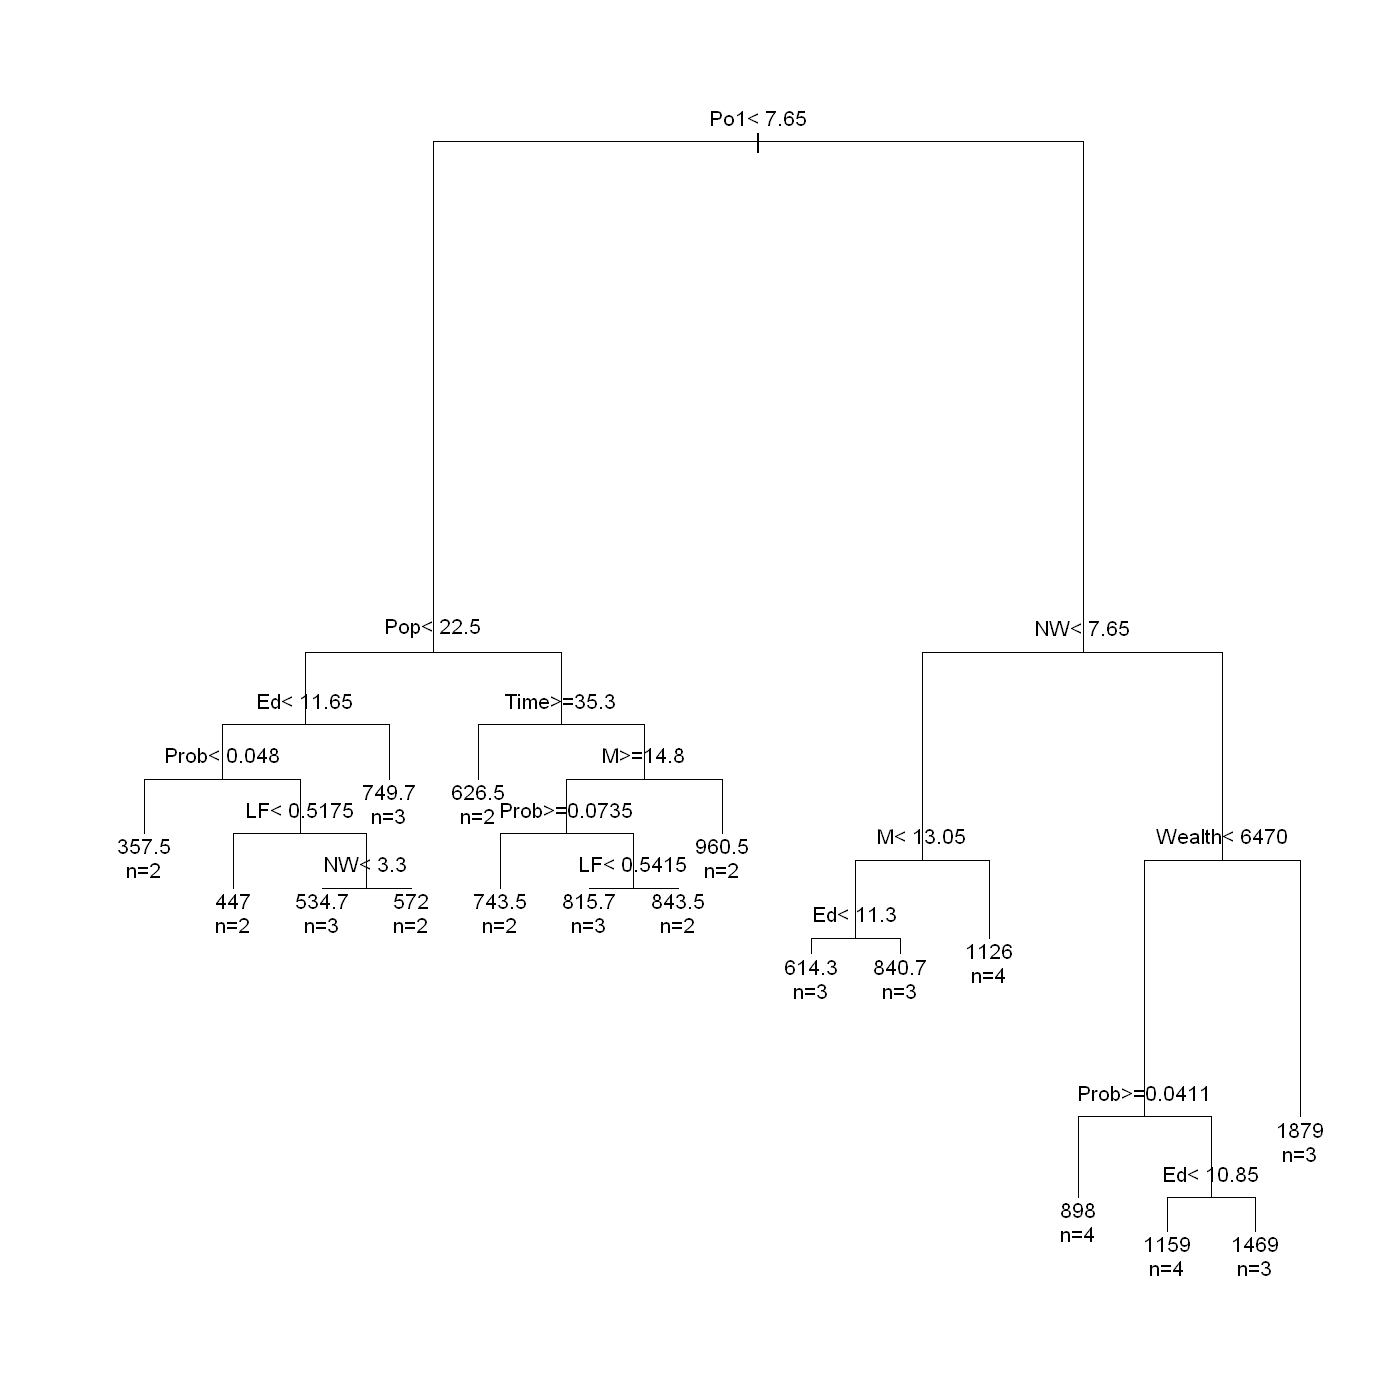

In [1]:
library(data.table)
library(rpart)
library(ggplot2)
library(magrittr)

options(warn=-1)

crime_dta <- fread('./hw7/uscrime.txt')
tree_control <- rpart.control(cp=0, maxdepth=20L, minsplit=5L, xval=nrow(crime_dta))
tree <- rpart(Crime ~ ., crime_dta, control=tree_control)

figsize <- 125
options(repr.plot.width = sqrt(figsize), repr.plot.height = sqrt(figsize), repr.plot.res = figsize)

par(xpd = TRUE)
plot(tree, compress = TRUE)
text(tree, use.n = TRUE)

## 1.2 Post-Pruning

A nice feature of the built-in `printcp` function and the `.$cptable` output value is that it internalizes the cross validation routine. It shows the relative error which is $1-R^2$ and the relative CV error corresponds to the columns `xerror`. Two [rules of thumb](https://bookdown.org/mpfoley1973/data-sci/regression-tree.html) for post-pruning: select tree with lowest relative CV SSE for best for lowest possible error. Or alternatively, prune to the smallest tree within 1 SE of the one with the smallest relative SSE. 

We use the latter rule for post-pruning. For the tree trained above, the best pruning would be at the first split, or `cp` equals 0.1654002424.

In [3]:
# code largely borrow from https://bookdown.org/mpfoley1973/data-sci/regression-tree.html
library(dplyr)

post_prune_tree <- function(tree, return_tree=FALSE) { 

    tab <- tree$cptable %>%
           data.frame() %>%
           mutate(min_xerror_idx = which.min(tree$cptable[, "xerror"]),
                  rownum = row_number(),
                  xerror_cap = tree$cptable[min_xerror_idx, "xerror"] + 
                     tree$cptable[min_xerror_idx, "xstd"],
                  eval = case_when(rownum == min_xerror_idx ~ "min xerror",
                                   xerror < xerror_cap ~ "under cap",
                                   TRUE ~ "")) %>% select(-rownum, -min_xerror_idx) %>% as.data.table
            
    if (return_tree==FALSE) {
        return(tab)
    } else {
        prune_cp <- tab[eval=="under cap"][1, CP]
        return(prune(tree, cp=prune_cp))    
    }

}

post_prune_diagnostics <- post_prune_tree(tree)
post_prune_diagnostics

CP,nsplit,rel.error,xerror,xstd,xerror_cap,eval
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.3629629325,0,1.00000000,1.043951,0.2612611,1.305212,min xerror
0.1654002424,1,0.63703707,1.144690,0.2883448,1.305212,under cap
0.0573014327,3,0.30623658,1.645859,0.3932568,1.305212,
0.0553886654,4,0.24893515,1.574746,0.3885601,1.305212,
0.0517316514,5,0.19354648,1.573788,0.3886082,1.305212,
0.0239290842,6,0.14181483,1.410100,0.3667461,1.305212,
0.0230593101,7,0.11788575,1.475646,0.3811656,1.305212,
0.0111671232,8,0.09482644,1.436872,0.3588562,1.305212,
0.0106378429,9,0.08365932,1.460477,0.3606309,1.305212,


#### Pruned Tree

The post-pruned tree which only features one split.

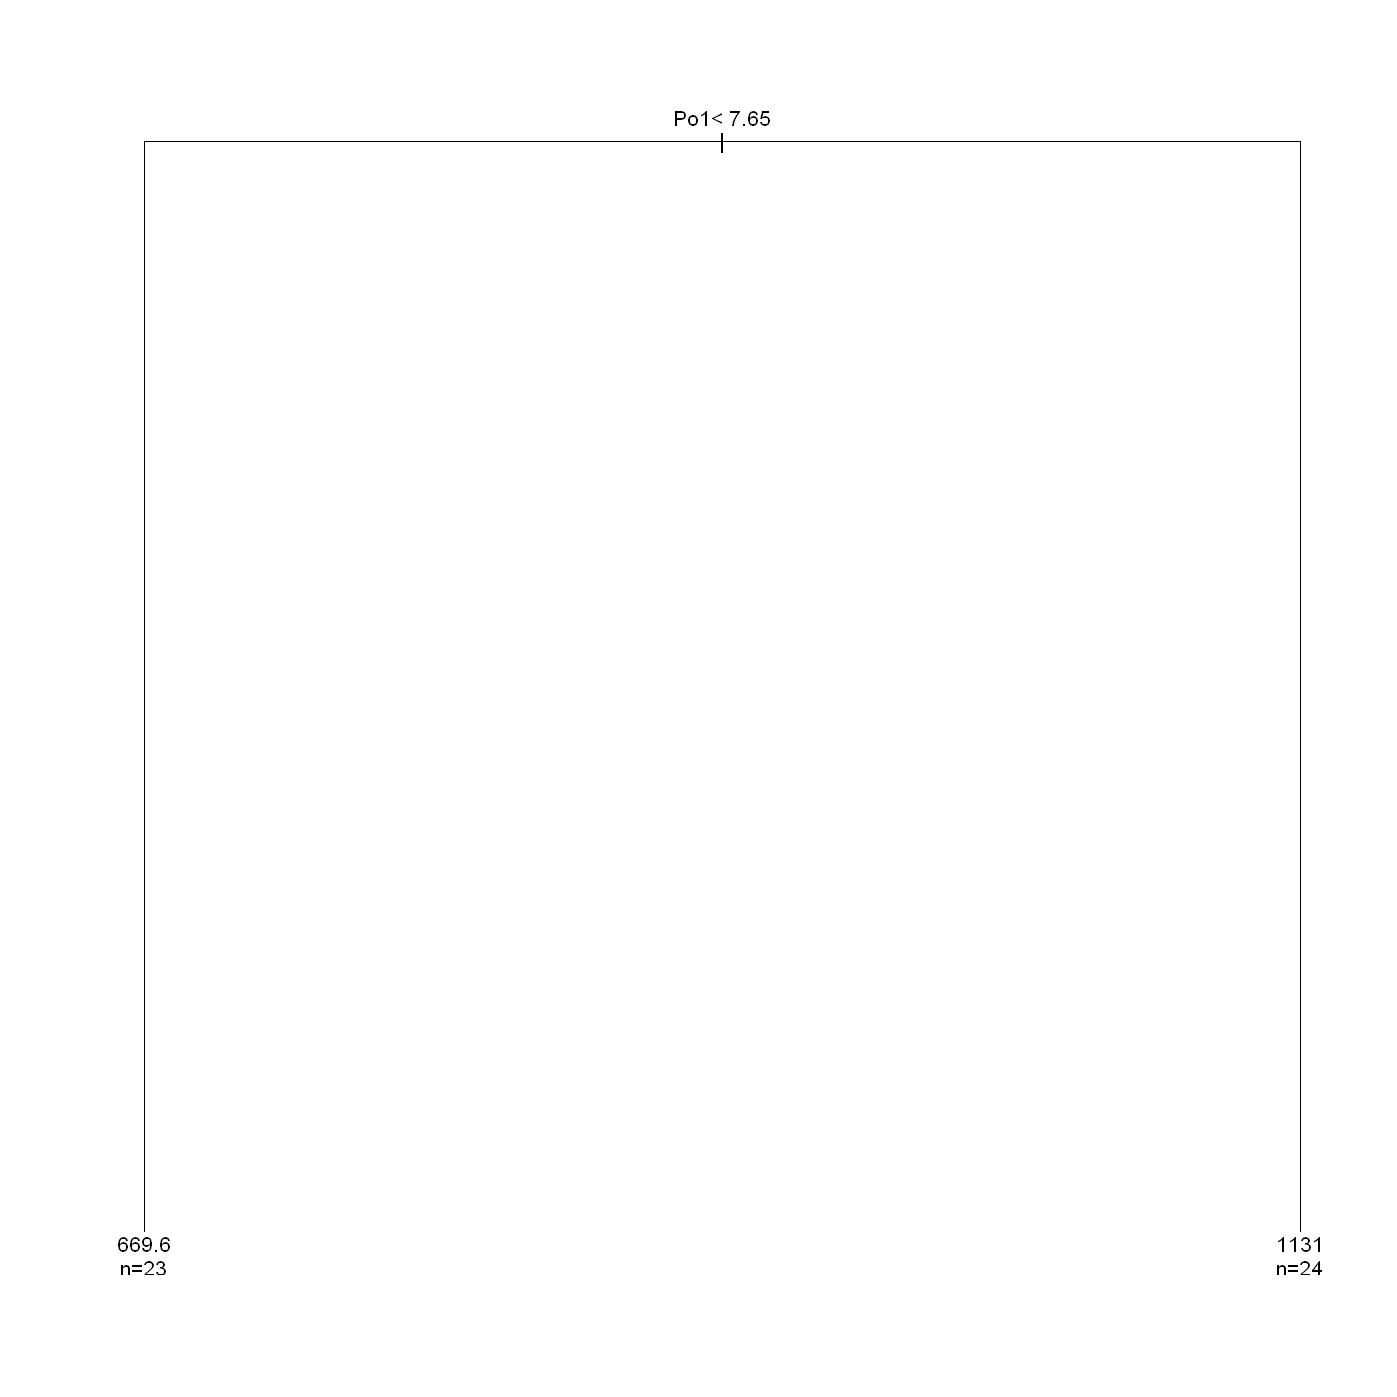

In [5]:
pruned_tree <- post_prune_tree(tree, return_tree=TRUE)
plot(pruned_tree, compress = TRUE)
text(pruned_tree, use.n = TRUE)

## 1.3 Model Selection

### Using LOOCV

Note that the CV and post-pruning process only constrains to a given metaparameter `minsplit` and `maxdepth`. Setting smaller `minsplit` allows the model to identify idiocyncratic strctures present in a small number of samples. Setting larger `maxdepth` relaxes the constraints for tree growing - so the model can continue splitting as long as there is gain in R squared and as permitted by `minsplit`. We would like to repeat the LOOCV post-pruning process above for tuning these parameters. 

The best model we'd select is the single node - i.e. not having any tree structure at all and predict crime for any state at the sample average.

In [8]:
split_grid <- c(2:20)
depth_grid <- c(2:20)

CV_tab <- data.table()
for (split in split_grid) {
    for (depth in depth_grid) {
        control <- rpart.control(cp=0, maxdepth=depth, minsplit=split, xval=nrow(crime_dta))
        pre_prune_tree <- rpart(Crime ~ ., crime_dta, control=control)
        pruned_tree <- post_prune_tree(pre_prune_tree, return_tree=TRUE)
        CV_err <- pruned_tree$cptable[nrow(pruned_tree$cptable), "xerror"]
        nsplit <- pruned_tree$cptable[nrow(pruned_tree$cptable), "nsplit"]
        tmp_tab <- data.table(split=split, depth=depth, CV_err=CV_err, splits=nsplit)
        CV_tab <- rbind(CV_tab, tmp_tab)
    }
}

In [9]:
CV_tab[which(CV_err==min(CV_err))]

split,depth,CV_err,splits
<int>,<int>,<dbl>,<dbl>
11,20,1.043951,0
12,9,1.043951,0
13,2,1.043951,0
13,5,1.043951,0
13,9,1.043951,0
13,17,1.043951,0
13,19,1.043951,0
14,6,1.043951,0
14,9,1.043951,0


### Using K-fold CV

If we're only doing a single run, we can only compare CV errors __across__ metaparameters __only for LOOCV__. We are still allowed to choose a $K$-fold CV to run the code, but it was found that the it has rather high variance - yielding high variation for each fixed metaparameter across different runs, thereby changing the selected models each time. Heterogeneity arises from variation of validation set partitions across metaparameters for each run so every set of metaparameter gets its own validation set - as `rpart` does not provide users' control over the validation set partition - so parameter sets with favorable training sets will have an advantage. 

A workaround here would be to have multiple runs for the model selection process. The idea is that with sufficient runs, we'd expect the the advantage of having assigned validation partition to average out. Even if we are able to fix the validation sets, we'd still benefit from doing mutliple runs. Because of the small data size, variations in training set partition can imply different orderings of CV errors across splits within each fixed parameter set.  

Using a repeated 10-fold CV for 59 times, we see that:
 - 1-split models appear the most time
 - all selected models will require >10 `minsplit`
 - `maxdepth` was never binding
 
We end up choosing a `minsplit` 20 (simplest model within chosen) and arbitrary `maxdepth`, with post-pruned 1 split. This is the post-pruned tree in section 1.2.

In [36]:
nested_tab <- data.table()
set.seed(1234)

for (i in 1:50) {
    CV_tab <- data.table()
    for (split in split_grid) {
        for (depth in depth_grid) {
            control <- rpart.control(cp=0, maxdepth=depth, minsplit=split, xval=10)
            pre_prune_tree <- rpart(Crime ~ ., crime_dta, control=control)
            pruned_tree <- post_prune_tree(pre_prune_tree, return_tree=TRUE)
            CV_err <- pruned_tree$cptable[nrow(pruned_tree$cptable), "xerror"]
            nsplit <- pruned_tree$cptable[nrow(pruned_tree$cptable), "nsplit"]
            tmp_tab <- data.table(round=i, minsplit=split, maxdepth=depth, CV_err=CV_err, nsplits=nsplit)
            CV_tab <- rbind(CV_tab, tmp_tab)
        }
    }
    nested_tab <- rbind(nested_tab, CV_tab[which(CV_err==min(CV_err))])
}

nested_tab[, .N, by=.(nsplits)]

nsplits,N
<dbl>,<int>
3,11
2,13
1,22
6,3
4,1


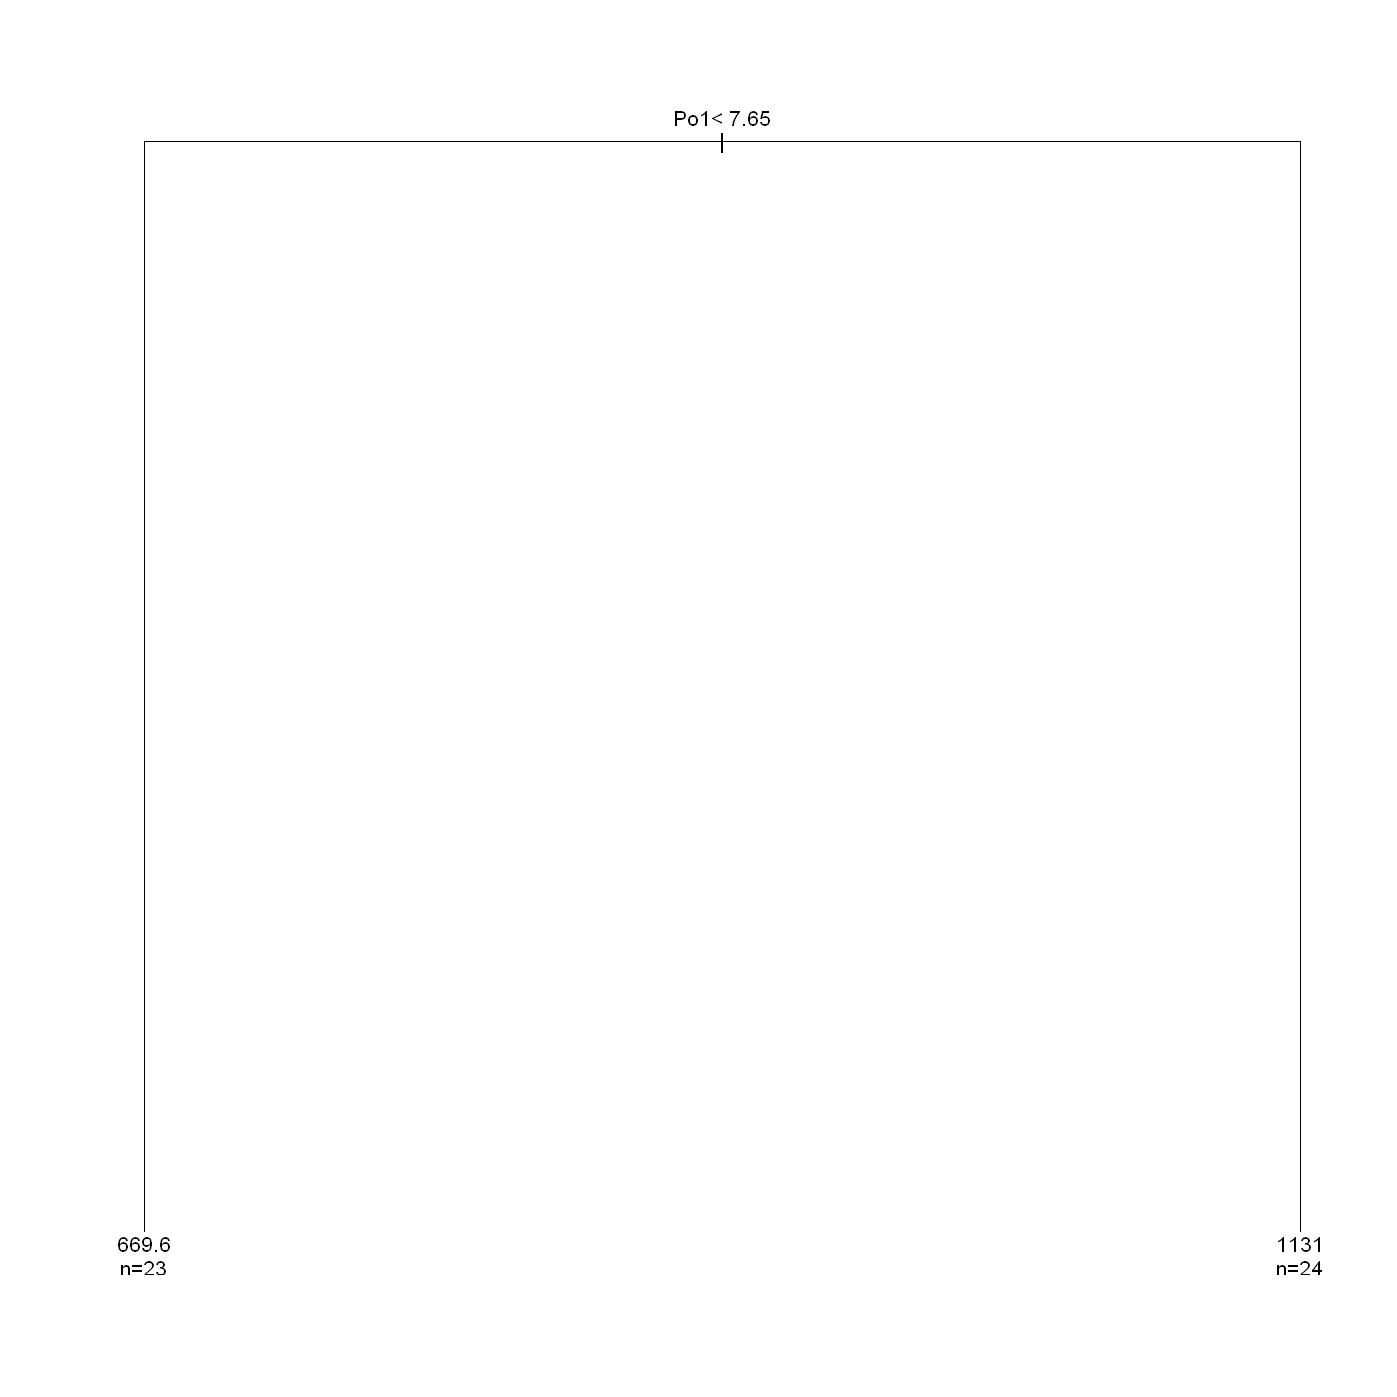

In [29]:
KCV_control <- rpart.control(cp=0, maxdepth=3, minsplit=20, xval=5)
pre_prune_tree <- rpart(Crime ~ ., crime_dta, control=KCV_control)
KCV_pruned_tree <- post_prune_tree(pre_prune_tree, return_tree=TRUE)

plot(KCV_pruned_tree)
text(KCV_pruned_tree, use.n = TRUE)

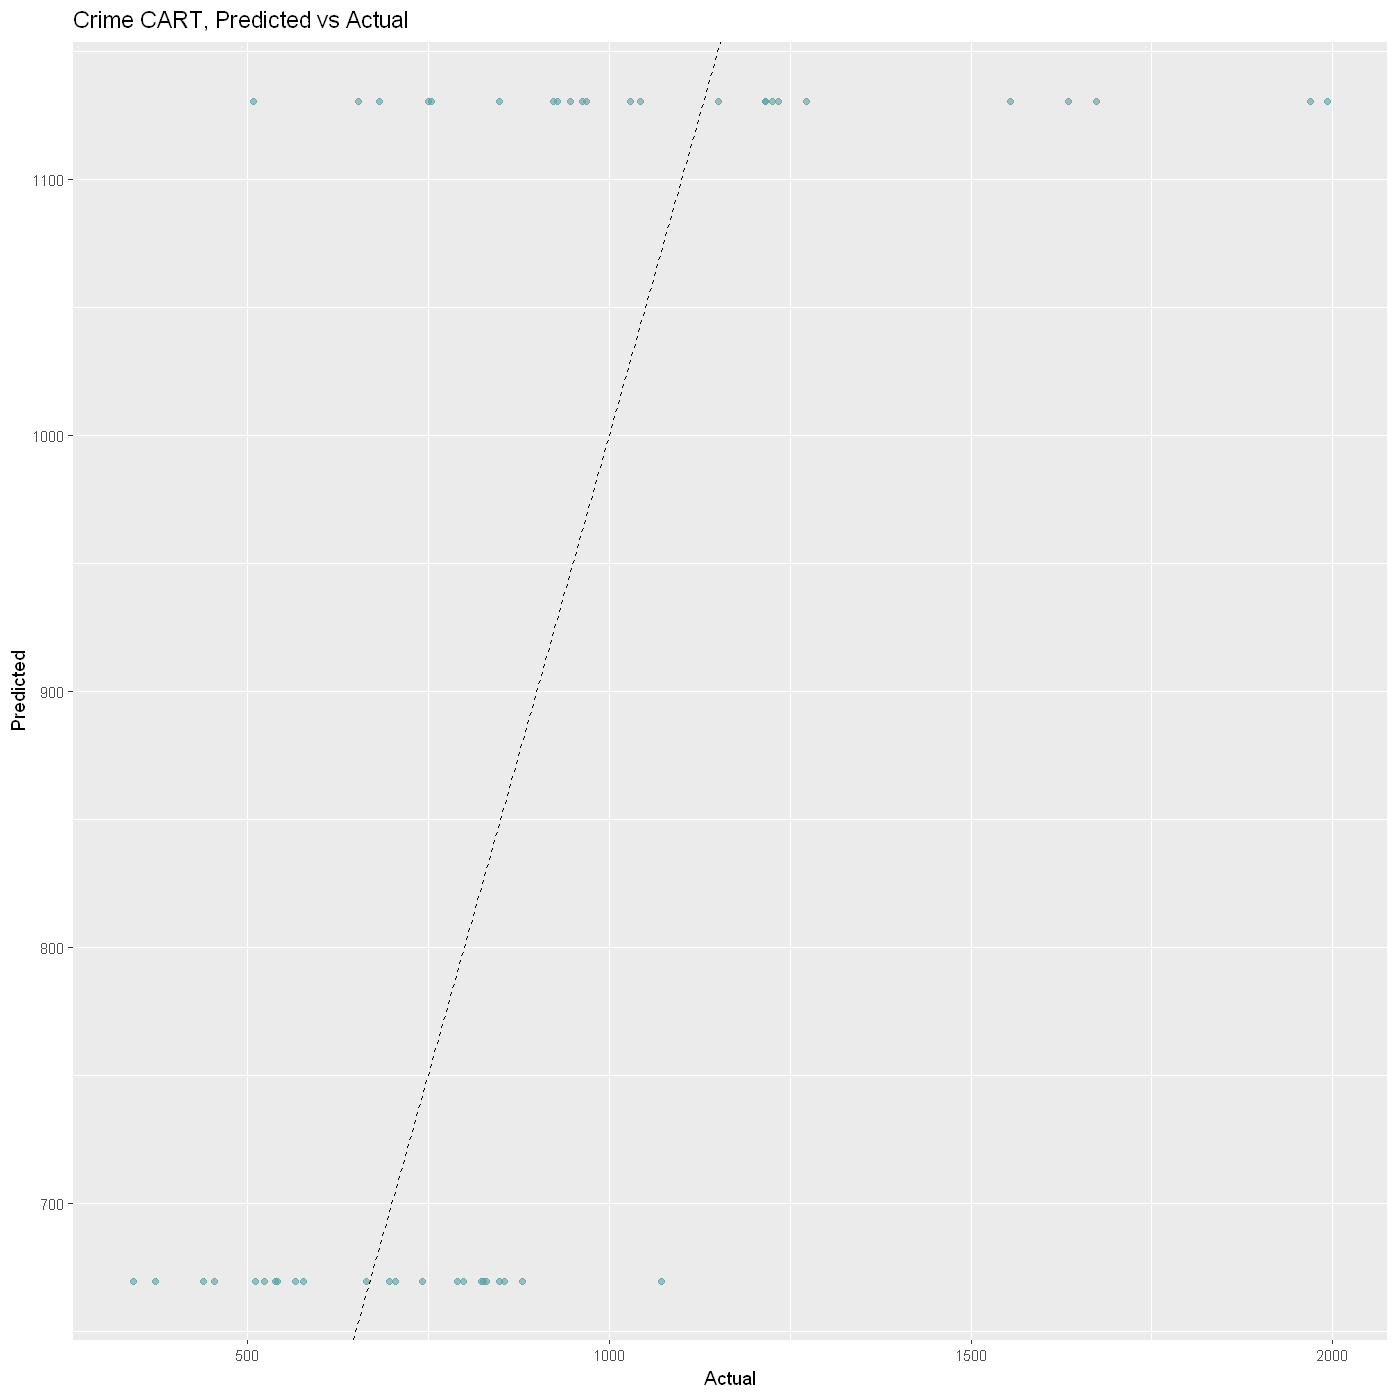

In [33]:
data.frame(Predicted = predict(KCV_pruned_tree), Actual = crime_dta[, Crime]) %>%
   ggplot(aes(x = Actual, y = Predicted)) +
   geom_point(alpha = 0.6, color = "cadetblue") +
   geom_abline(intercept = 0, slope = 1, linetype = 2) +
   labs(title = "Crime CART, Predicted vs Actual")

## 2.1 Training Random Forest

We will be using `randomForest` for training RF models in the data set. 

```R
randomForest(formula, data=NULL, ..., subset, na.action=na.fail)
```

Some notable parameters:
- `ntree`: Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
- `mtry`: Number of variables randomly sampled as candidates at each split. If there are $K$ features, a rule of thumb is to take $\sqrt{K}$ for classification, and $\frac{K}{3}$ for regression.
- `nodesize`: Minimum size of terminal nodes. Setting this number larger causes smaller trees to be grown (and thus take less time). Note that the default values are different for classification (1) and regression (5).
- `sampsize`: Bootstrap size.
- `importance`: Logical value on whether importance of predictors should be assessed. Here the permutation feature importance is being used. 
- `nPerm`: Number of times the out-of-bag data (leftover samples in bootstrap sampling) are permuted per tree for assessing variable importance. Number larger than 1 gives slightly more stable estimate, but not very effective. Currently only implemented for regression.
- `keep.inbag`: Logical value on whether an n by ntree matrix should be returned that keeps track of which samples are "in-bag" in which trees. To be accessed by `.$inbag`.

Out-of-bag MSE and pseudo-R2 are returned as `.$mse` and `.$rsq`. Some notable methods under the package:
- `plot()`: Plot the out-of-bag error rates or MSE of a randomForest object across the number of trees included in forest.
- `predict)_`: Make predictions.
- `importance()`: Table for variable importance measures for each feature. Definition of the importance will be discussed below.
- `varImpPlot()`: Plot the permutation feature importance for each predictor.
- `partialPlot()`: Partial dependence plot gives a graphical depiction of the marginal effect of a variable $x$ on $y$ implied by a random forest model.
- `tuneRF()`: Built-in routine for tuning `mtry`.
- `rfcv()`: Routine for using random forest to select features (see [here](https://stats.stackexchange.com/questions/233863/mtry-in-rfcv-function-in-randomforest-in-r) for an example of usage).

As a starter, here's the trained random forest model under the default parameter values. We see that as the number of trees increased, the prediction power also increased in general.

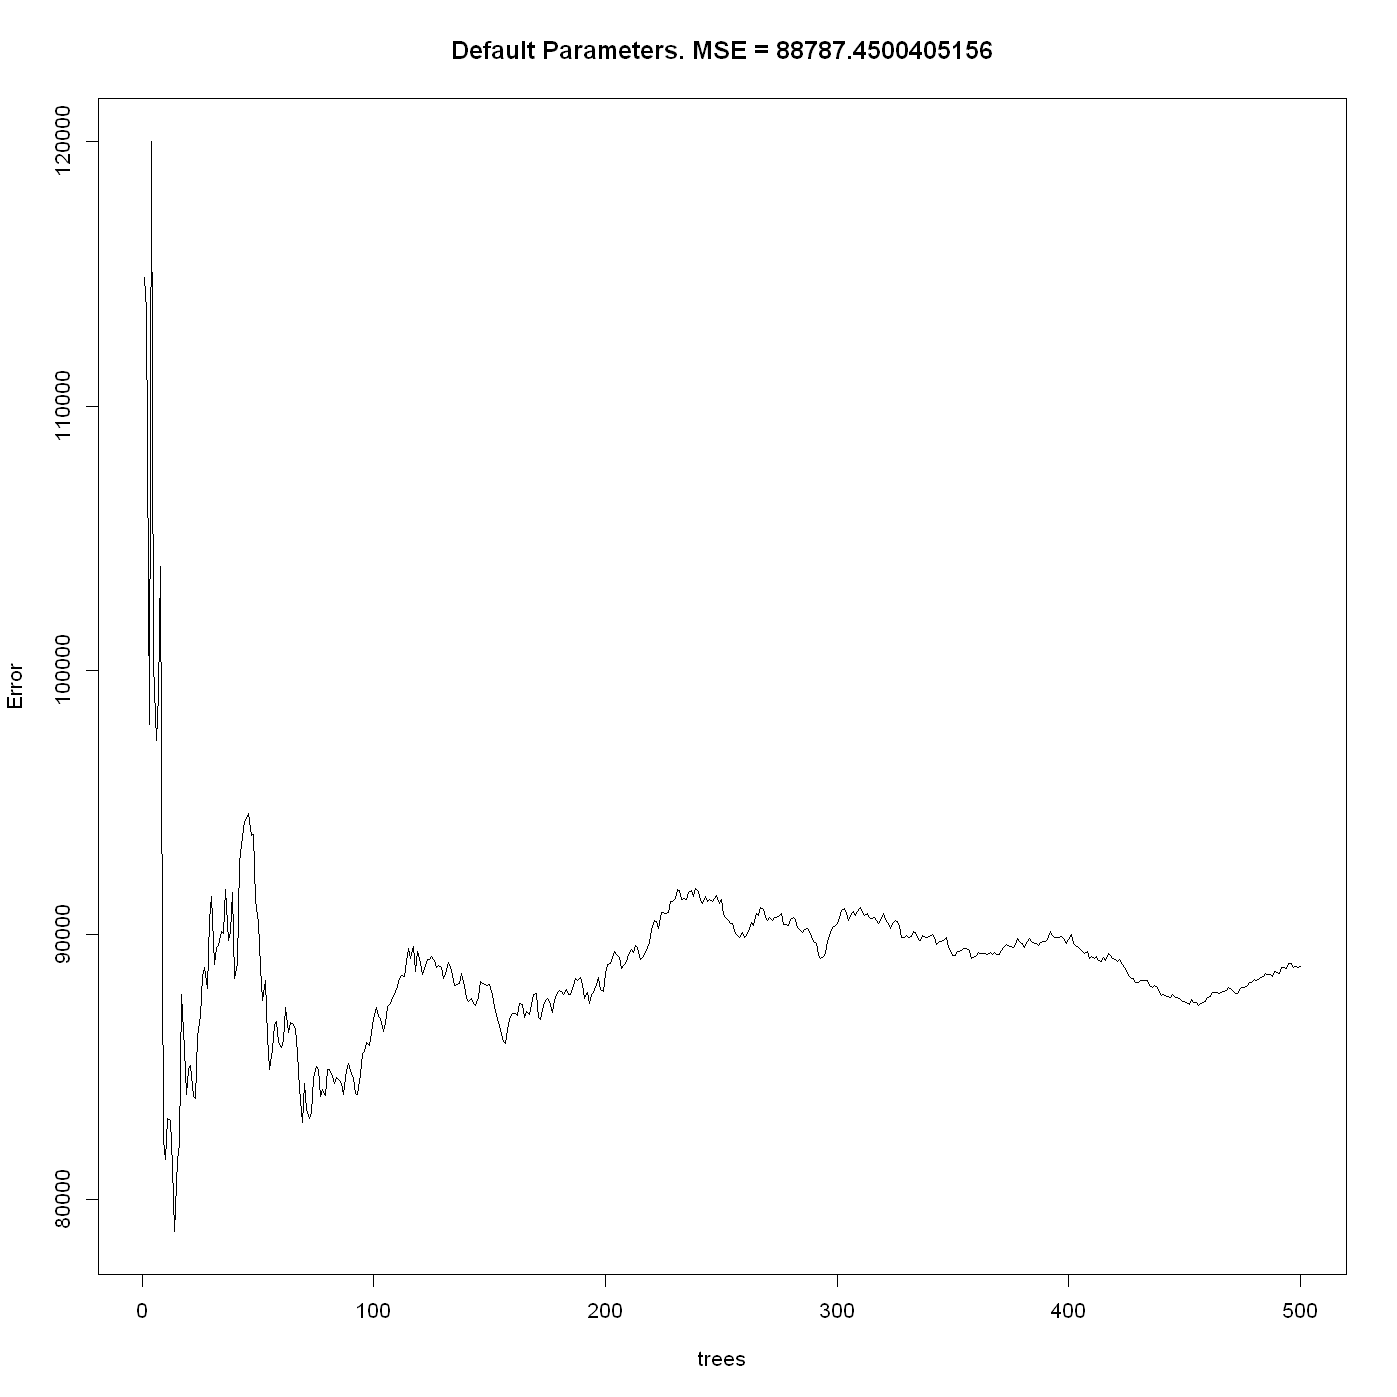

In [204]:
library(caret)
library(randomForest)

RF0 <- randomForest(Crime ~ ., crime_dta)
plot(RF0, main=paste("Default Parameters. MSE =", RF0$mse[length(RF0$mse)]))

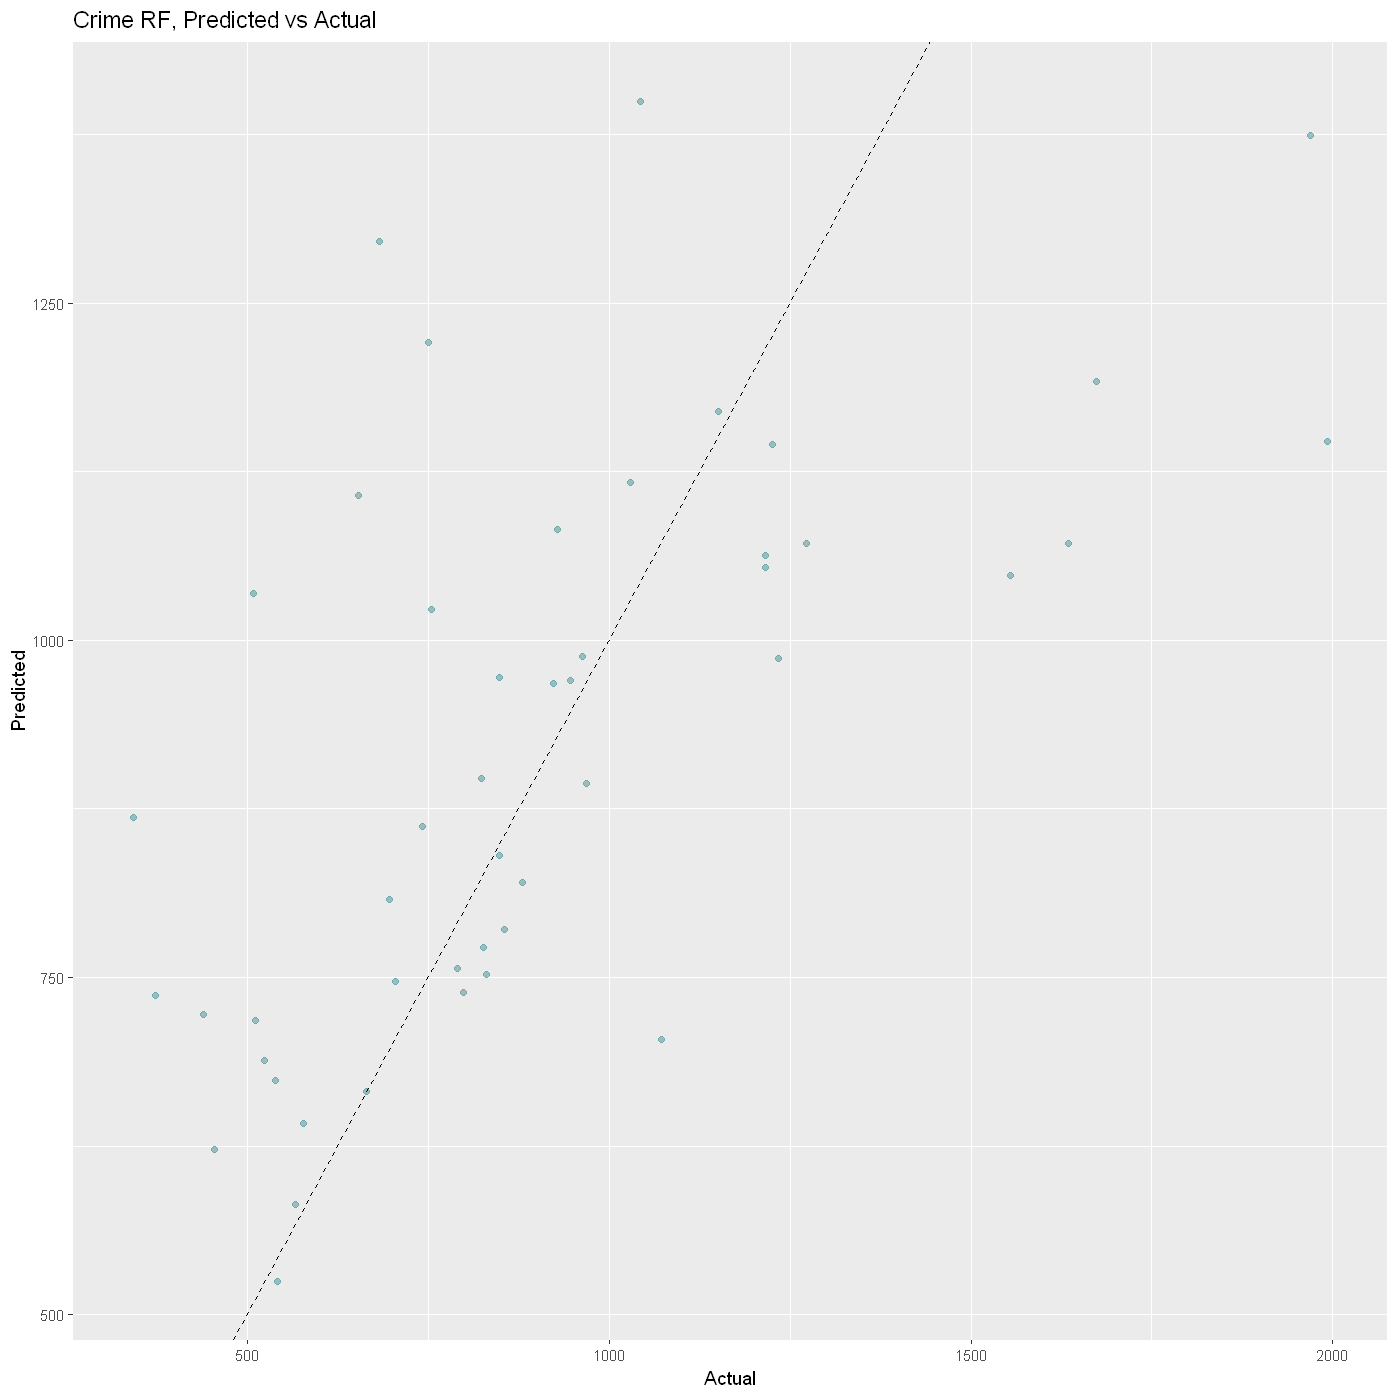

In [205]:
data.frame(Predicted = predict(RF0), Actual = crime_dta[, Crime]) %>%
   ggplot(aes(x = Actual, y = Predicted)) +
   geom_point(alpha = 0.6, color = "cadetblue") +
   geom_abline(intercept = 0, slope = 1, linetype = 2) +
   labs(title = "Crime RF, Predicted vs Actual")

## 2.2 Model Selection

Performance of the algorithm is affected by the parameters. For example, having more `ntrees` will create a efficiency-accuracy tradeoff, with the small data at hand we should be able to fit as many trees as needed. As seen from the MSE graph above around 100 trees would suffice. Having less `mtry` induces diversity among the trees, but at a performance tradeoff. Having smaller `nodesize` allows the trees to grow deeper, but at the expense of overfitting.

We would like to do LOOCV and a 10-fold CV (repeated 5 times) for the tuning `ntrees`, `mtry`, and `nodesize`. Because of the lack of built-in CV structures, we will use relevant facilities in the `caret` package as demonstrated in [here](https://rpubs.com/phamdinhkhanh/389752) and [here](https://topepo.github.io/caret/model-training-and-tuning.html).

We end up choosing models with:
- LOOCV: 100 trees, 2 observations to split, 3 features
- 10-fold CV: 500 trees, 2 observations to split, 3 features

In either case, we have `nodesize` and `mtry` at 2 and 3. Regarding the number of trees, Leo Breiman, the author of this algorithm in the [official page of this algorithm](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#remarks), random forest does not overfit, and you can use as many trees as you want. We'll take 500 trees. (Note: in [this thread](https://stats.stackexchange.com/questions/36165/does-the-optimal-number-of-trees-in-a-random-forest-depend-on-the-number-of-pred/36183) it was pointed out that one paper in the literature found overfitting with too many trees. For the purpose of this assignment, we acknowledge this fact without further investigation.)

In [186]:
tunegrid <- expand.grid(.mtry = c(2:15))

# LOOCV
seed <- 123
control <- trainControl(method = 'LOOCV',
                        number = 1,
                        # seed = as.list(rep(seed,nrow(crime_dta))),
                        search = 'grid')

ntree_grid <- c(100,500,1000)
nodesize_grid <- c(2,5,10,15,20)
modellist <- list()

for (ntree in ntree_grid){
    for (nodesize in nodesize_grid) {
      set.seed(seed)
      fit <- train(Crime~.,
                   data = crime_dta,
                   method = 'rf',
                   metric = 'mse',
                   tuneGrid = tunegrid,
                   trControl = control,
                   ntree = ntree,
                   nodesize = nodesize)
      key <- paste(ntree, nodesize)
      modellist[[key]] <- fit
    }
}

get_model <- function(x) {
    tab <- modellist[[x]]$results %>% data.table
    best_mod <- tab[which.min(RMSE)]
    res <- data.table(model=x, mtry=best_mod[, mtry], RMSE=best_mod[, RMSE])
}

res <- lapply(names(modellist), get_model) %>% rbindlist
res[order(RMSE)]

model,mtry,RMSE
<chr>,<int>,<dbl>
100 2,3,280.9644
1000 2,6,283.4495
500 2,6,284.8575
1000 5,5,286.5803
100 5,3,287.5580
100 10,3,287.6619
500 5,4,287.6957
500 10,3,294.0733
1000 10,4,294.1511


#### 10-fold CV results

Note that R Squared is minimized at `ntree`=500 and `nodesize`=2. Further inspection in the result indicates `mtry`=3 (see below).

In [188]:
# 10-fold CV
seed <- 123
KCV_control <- trainControl(method = 'repeatedcv',
                        number = 10,
                        repeats = 5,
                        # seed = as.list(rep(seed,nrow(crime_dta))),
                        search = 'grid')

for (ntree in ntree_grid){
    for (nodesize in nodesize_grid) {
      set.seed(seed)
      fit <- train(Crime~.,
                   data = crime_dta,
                   method = 'rf',
                   metric = 'mse',
                   tuneGrid = tunegrid,
                   trControl = KCV_control,
                   ntree = ntree,
                   nodesize = nodesize)
      key <- paste(ntree, nodesize)
      modellist[[key]] <- fit
    }
}

#Compare results
results <- resamples(modellist)
summary(results)


Call:
summary.resamples(object = results)

Models: 100 2, 100 5, 100 10, 100 15, 100 20, 500 2, 500 5, 500 10, 500 15, 500 20, 1000 2, 1000 5, 1000 10, 1000 15, 1000 20 
Number of resamples: 50 

MAE 
            Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
100 2   58.35800 148.1451 206.2933 206.1749 248.4681 358.2262    0
100 5   57.72717 157.2054 202.3856 208.7217 261.1591 343.6686    0
100 10  54.38939 146.2770 214.7113 211.3349 272.9939 351.2913    0
100 15  54.61732 174.4790 218.9753 222.1800 273.3591 394.7073    0
100 20  69.07359 168.2678 235.8687 227.7576 282.6256 387.5877    0
500 2   60.28420 154.7207 207.4963 205.4729 256.2047 344.1460    0
500 5   65.14705 156.5160 203.6507 207.1166 257.9154 333.6759    0
500 10  66.72040 158.1772 211.2238 214.9898 265.4611 353.2552    0
500 15  68.41500 159.5634 220.1608 221.5986 283.0853 363.4512    0
500 20  66.40811 167.4614 230.4967 229.1063 283.9486 379.0307    0
1000 2  59.91880 151.5254 206.4641 206.0336 259.4923 340.3967

In [192]:
modellist[["500 2"]]

Random Forest 

47 samples
15 predictors

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 42, 42, 42, 42, 42, 44, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    268.9891  0.6273569  209.5395
   3    265.5956  0.6287804  205.4729
   4    267.7912  0.6212190  205.0473
   5    267.5044  0.6158869  204.7332
   6    268.8467  0.6100712  205.9142
   7    271.2848  0.6147168  207.2682
   8    270.8581  0.6067109  208.0100
   9    272.1794  0.6011557  209.7031
  10    275.9495  0.5920464  211.4823
  11    277.8157  0.5873282  214.6863
  12    277.5751  0.5951192  213.1284
  13    276.6496  0.5885748  213.1184
  14    279.1100  0.5871404  214.3438
  15    279.9499  0.5848206  215.5169

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 3.

## 3. Qualitative Analysis

It would be straightforward to analyze the selected CART: `Po1` the police expenditure in 1960 will suffice to explain the crime rate in the same year. We should note that, however, the MSE for a linear regression model with heuristic variable selection scheme had LOOCV around 70,000 which is significantly better than the CART - so we should take this conclusion with a grain of salt.

For random forest even though it is often noted for its lack of direct interpretability, there are still tools available for qualitative analysis. The permutation importance for features will be one. According to [this](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e) medium post on feature importance, it is computed as follows:

1. Train the baseline model and record the score (accuracy/R Squared/other metric of importance) for the out-of-bag set. 
2. Re-shuffle values from one feature in the selected dataset, pass the dataset to the model again to obtain predictions and calculate the metric for this modified dataset. The feature importance is the difference between the benchmark score and the one from the modified (permuted) dataset.
3. Repeat step 2 for another feature.

Caveat: It was noted that the difference between benchmark and the permuted dataset in step 2 [only involves trees that used that particular feature](https://medium.com/@azuranski/permutation-feature-importance-in-r-randomforest-26fd8bc7a569) - which deviates from the formal definition.

### Permutation Feature Importance Plot

We see that `Po1` and `Po2` are the most important. Again, this is very suspicious because we have seen `Po1` and `Po2` highly correlated, so if any of them is the most important feature, the other should not - in a sense that the other value is being controlled for (_ceteris paribus_). In fact, it is [warned in the data scientist community](https://towardsdatascience.com/stop-permuting-features-c1412e31b63f) that permutation importance has several problems, especially when working with correlated features. Scholars even urged, ["Please Stop Permuting Features: An Explanation and Alternatives"](https://towardsdatascience.com/stop-permuting-features-c1412e31b63f). 

Another way to evaluate feature importance mentioned in [the post above](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e) is to consider the change in accuracy metric between the benchmark, and a dataset that has that particular feature dropped. We acknowledge this fact without implementation.

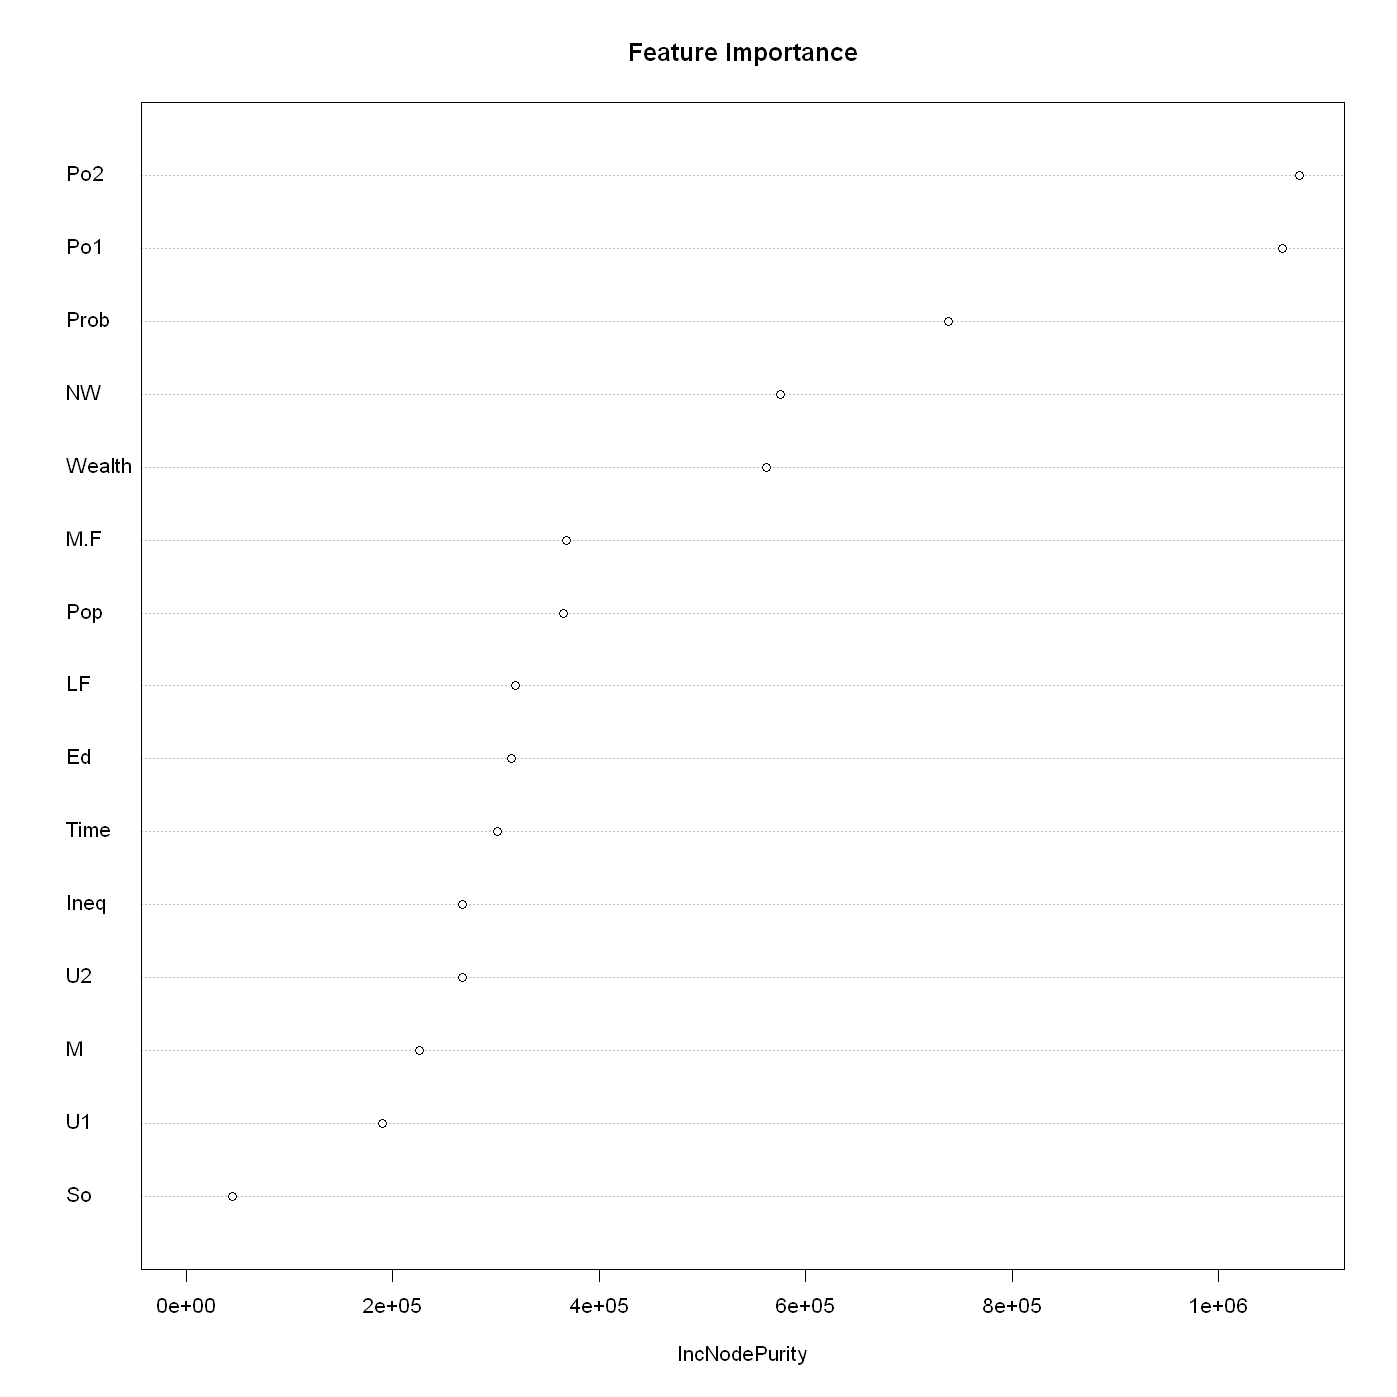

In [203]:
set.seed(seed)
RF2 <- randomForest(Crime ~ ., crime_dta, ntrees=500, nodesize=2, mtry=3)

varImpPlot(RF2, main="Feature Importance")

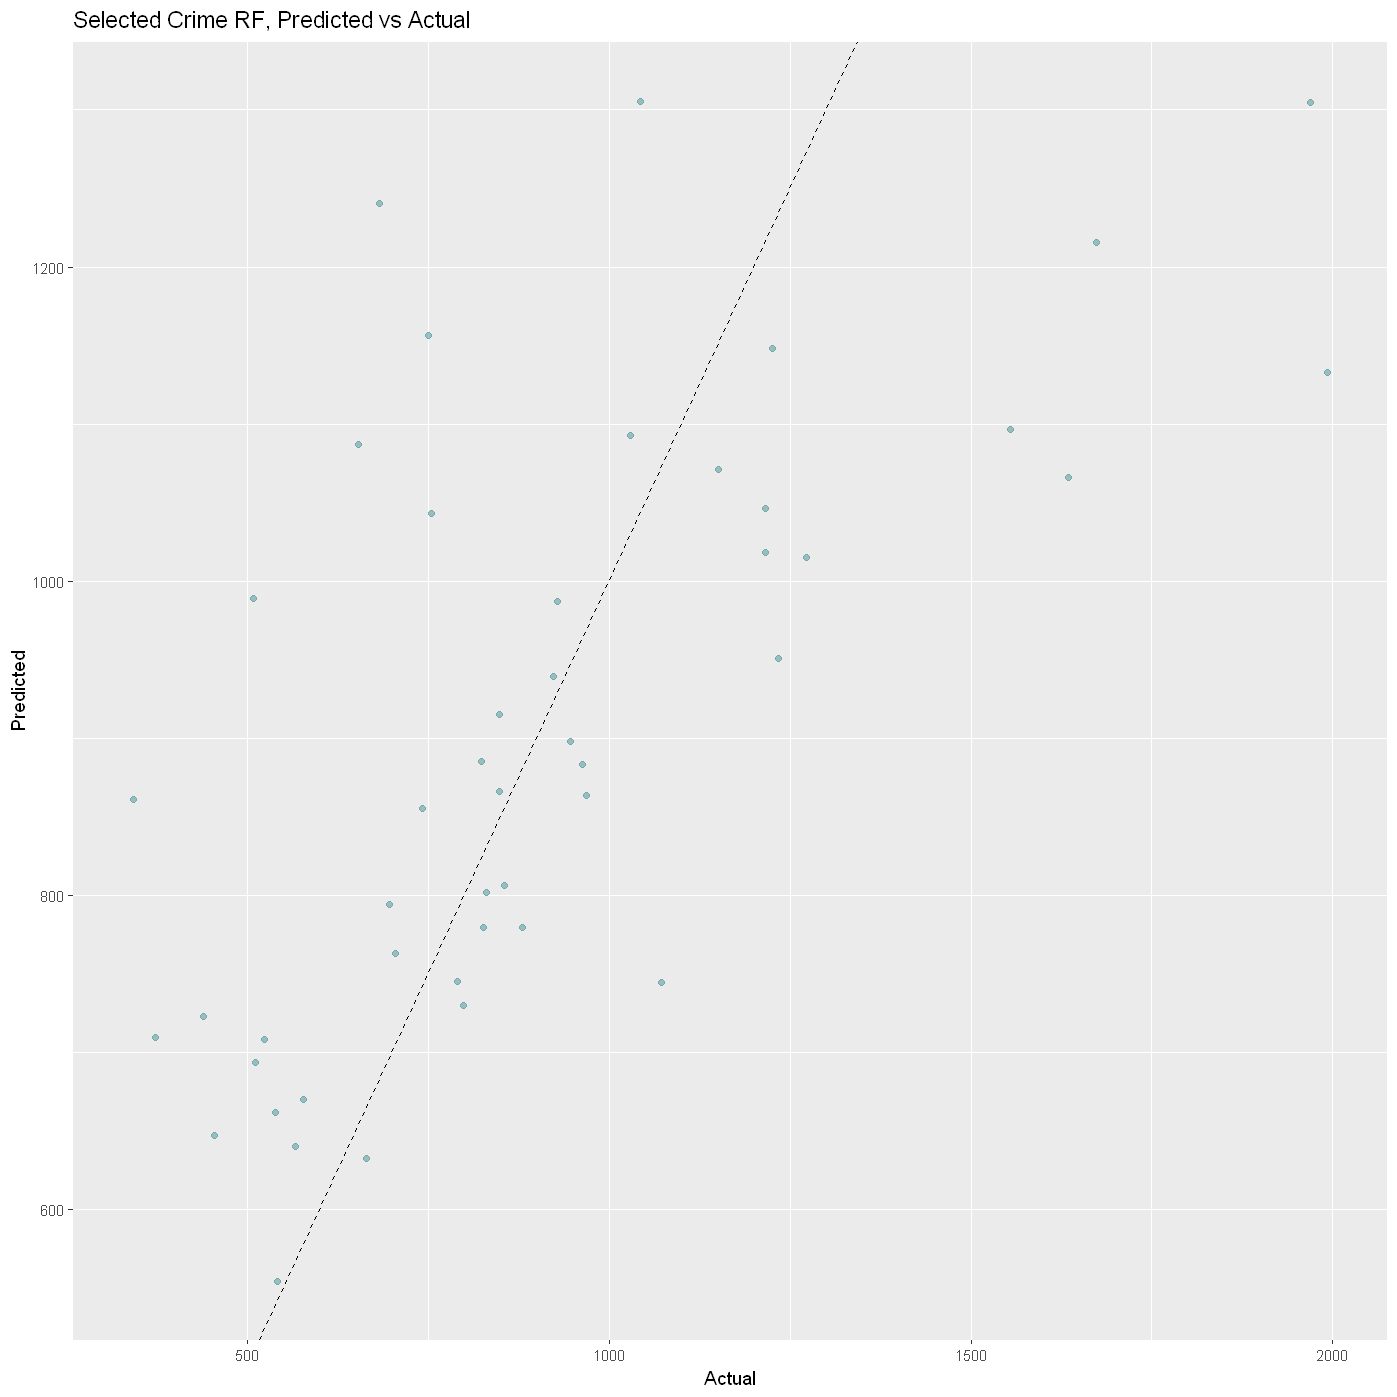

In [210]:
data.frame(Predicted = predict(RF2), Actual = crime_dta[, Crime]) %>%
   ggplot(aes(x = Actual, y = Predicted)) +
   geom_point(alpha = 0.6, color = "cadetblue") +
   geom_abline(intercept = 0, slope = 1, linetype = 2) +
   labs(title = "Selected Crime RF, Predicted vs Actual")

# Question 10.2

Describe a situation or problem from your job, everyday life, current events, etc., for which a logistic regression model would be appropriate. List some (up to 5) predictors that you might use.

# Answer to 10.2

In the reference article, it was noted that in-game purchase decisions for players are fitted by logistic regressions. Being a mobile gamer myself, I can relate to the need of modeling - because most mobile games are essentially free, a machine for learning the preference for players will be vital to capitalize large player networks, by converting free-to-play players to pay-to-win players and to publish attractive contents keep them.

A logistic regression in this context could be denominated in each player (what's P(buy|player and product characteristic) for each player) and then the expected profits can be computed by summing expected profits (price $\times$ P(buy)) across the player base. This will involve a training data with a pool of sampled players (converted and non-converted) with a binary response of purchase. Alternatively, the regression can be a panel for each product, showing the aggregated characteristics for players and the product characteristics over a period, say, a day. The latter is faster to run as it involes less data but sacrificed correlation between buyers' characteristics and product characteristics. 

We consider the first type: player-based logistic regerssion on P(buy). I think the following predictor would make sense:
- __Exposure to advertising campaign__ - tracking whether player converted from an ad, or was exposed to any promotion materials.
- __Historical behavior__ - whether the player had made a purchase previously, or hours spent playing.
- __Network variables__ - whether the player likes to play with other players (PVP), or just built-in events (PVE). Whether their peers made purchases or not etc.
- __Product characteristcs__ - product style, could require domain specifc knowledge, e.g. appeals of characters (flags like cool, cute etc), price of product.
- __Time-specific variables__ - would be useful to control for punctual events such as Christmas, summer breaks. Interact with other predictors to capture change of preference.

Reference: [Active Wizards](https://activewizards.com/blog/5-real-world-examples-of-logistic-regression-application)

# Question 10.3

1.	Using the GermanCredit data set `germancredit.txt` from http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german / (description at http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29 ), use logistic regression to find a good predictive model for whether credit applicants are good credit risks or not.  Show your model (factors used and their coefficients), the software output, and the quality of fit.  You can use the `glm` function in R. To get a logistic regression (logit) model on data where the response is either zero or one, use family=binomial(link=”logit”) in your glm function call.

2.	Because the model gives a result between 0 and 1, it requires setting a threshold probability to separate between "good" and "bad" answers.  In this data set, they estimate that incorrectly identifying a bad customer as good, is 5 times worse than incorrectly classifying a good customer as bad.  Determine a good threshold probability based on your model.


# Answers to 10.3

## 1.1 Cleaning Data

This dataset classifies people described by a set of attributes as good or bad credit risks. There are a total of 21 attributes in the dataset (copied from [here](https://rpubs.com/Rohit_Bhaya/388435)). Their descriptions and details have been tabulated below:

- Status of existing checking account.
- Credit duration in months
- Credit history
- Purpose
- Credit amount
- Savings account/bonds
- Present employment since
- Installment rate in percentage of disposable income
- Personal status and sex
- Other debtors / guarantors
- Present residence since
- Property
- Age in years
- Other installment plans
- Housing Status
- Number of existing credits at this bank
- Job Category
- Number of people being liable to provide maintenance for
- Registered Telephone
- Foreign worker

I'll first change the variable names, then encode the categorical features with meaningful strings.

In [362]:
credit_dta <- fread('./hw7/germancredit.txt')
names(credit_dta) <- c('chk_acct',
                       'credit_dur',
                       'credit_hist',
                       'purpose',
                       'credit_amt',
                       'sav_acct',
                       'employ_since',
                       'instl_rate',
                       'sex_marriage',
                       'debtor_guarantor',
                       'reside_since',
                       'property',
                       'age',
                       'other_instl',
                       'housing',
                       'n_credits',
                       'job_cat',
                       'n_liable_ppl',
                       'reg_phone',
                       'foreign',
                       'credibility')

credit_dta[, credibility := credibility-1]
credit_dta[, reg_phone:=as.numeric(reg_phone=='A192')]
credit_dta[, foreign:=as.numeric(foreign=='A201')]

credit_dta[chk_acct=='A11', chk_acct:='Neg']
credit_dta[chk_acct=='A12', chk_acct:='<200']
credit_dta[chk_acct=='A13', chk_acct:='>=200']
credit_dta[chk_acct=='A14', chk_acct:='None']
credit_dta[credit_hist=='A30', credit_hist:='all_duly']
credit_dta[credit_hist=='A31', credit_hist:='bank_duly']
credit_dta[credit_hist=='A32', credit_hist:='till_now']
credit_dta[credit_hist=='A33', credit_hist:='delays']
credit_dta[credit_hist=='A34', credit_hist:='critical']
credit_dta[purpose=='A40', purpose:='new_car']
credit_dta[purpose=='A41', purpose:='used_car']
credit_dta[purpose=='A42', purpose:='furn']
credit_dta[purpose=='A43', purpose:='radio_TV']
credit_dta[purpose=='A44', purpose:='appliances']
credit_dta[purpose=='A45', purpose:='repairs']
credit_dta[purpose=='A46', purpose:='edu']
credit_dta[purpose=='A47', purpose:='vacation']
credit_dta[purpose=='A48', purpose:='retraining']
credit_dta[purpose=='A49', purpose:='business']
credit_dta[purpose=='A50', purpose:='others']
credit_dta[sav_acct=='A61', sav_acct:='<100']
credit_dta[sav_acct=='A62', sav_acct:='<500']
credit_dta[sav_acct=='A63', sav_acct:='<1000']
credit_dta[sav_acct=='A64', sav_acct:='>=1000']
credit_dta[sav_acct=='A65', sav_acct:='None']
credit_dta[employ_since=='A71', employ_since:='unemployed']
credit_dta[employ_since=='A72', employ_since:='<1']
credit_dta[employ_since=='A73', employ_since:='<4']
credit_dta[employ_since=='A74', employ_since:='<7']
credit_dta[employ_since=='A75', employ_since:='>=7']
credit_dta[sex_marriage=='A91', sex_marriage:='M_div']
credit_dta[sex_marriage=='A92', sex_marriage:='F_div']
credit_dta[sex_marriage=='A93', sex_marriage:='M_single']
credit_dta[sex_marriage=='A94', sex_marriage:='M_married']
credit_dta[sex_marriage=='A95', sex_marriage:='F_single']
credit_dta[debtor_guarantor=='A101', debtor_guarantor:='none']
credit_dta[debtor_guarantor=='A102', debtor_guarantor:='co-applicant']
credit_dta[debtor_guarantor=='A103', debtor_guarantor:='guarantor']
credit_dta[property=='A121', property:='real_est']
credit_dta[property=='A122', property:='soc_sav']
credit_dta[property=='A123', property:='car']
credit_dta[property=='A124', property:='None']
credit_dta[other_instl=='A141', other_instl:='bank']
credit_dta[other_instl=='A142', other_instl:='store']
credit_dta[other_instl=='A143', other_instl:='None']
credit_dta[housing=='A151', housing:='rent']
credit_dta[housing=='A152', housing:='own']
credit_dta[housing=='A153', housing:='free']
credit_dta[job_cat=='A171', job_cat:='unemployed']
credit_dta[job_cat=='A172', job_cat:='unskilled']
credit_dta[job_cat=='A173', job_cat:='skilled']
credit_dta[job_cat=='A174', job_cat:='management']

cat_features <- c('chk_acct', 'credit_hist', 'purpose', 'sav_acct', 'employ_since', 'sex_marriage', 'debtor_guarantor',
                  'property', 'other_instl', 'housing', 'job_cat')

df <- as.data.frame(credit_dta)
df[cat_features] <- lapply(df[cat_features] , factor)

## 1.2 Fitting Logistic Regression Data

Most signs of the coefficients are making sense - having no checking accounts and saving decreases one's credibility, etc. In my opinion, it makes economic sense to include all predictors in the model. Some factor variables, say, `employed_since` at `unemployed` and `job_cat` at `unemployed` seem to be confounding. We can use `glmnet` to fit a Lasso if needed. 

In [364]:
logit_reg <- glm(credibility ~ ., , family = binomial, data = df)

library(tab)
tabglm(logit_reg) %>% kable()

Waiting for profiling to be done...





|Variable                 |Beta (SE)    |OR (95% CI)        |P      |
|:------------------------|:------------|:------------------|:------|
|Intercept                |-2.77 (1.35) |-                  |0.04   |
|chk_acct                 |             |                   |       |
|\ \ \ <200 (ref)         |-            |-                  |-      |
|\ \ \ >=200              |-0.59 (0.37) |0.55 (0.26, 1.13)  |0.11   |
|\ \ \ Neg                |0.37 (0.22)  |1.45 (0.95, 2.23)  |0.09   |
|\ \ \ None               |-1.34 (0.23) |0.26 (0.17, 0.41)  |<0.001 |
|credit_dur               |0.03 (0.01)  |1.03 (1.01, 1.05)  |0.003  |
|credit_hist              |             |                   |       |
|\ \ \ all_duly (ref)     |-            |-                  |-      |
|\ \ \ bank_duly          |0.14 (0.55)  |1.15 (0.39, 3.39)  |0.79   |
|\ \ \ critical           |-1.44 (0.44) |0.24 (0.10, 0.56)  |0.001  |
|\ \ \ delays             |-0.85 (0.47) |0.43 (0.17, 1.06)  |0.07   |
|\ \ \ till_now   

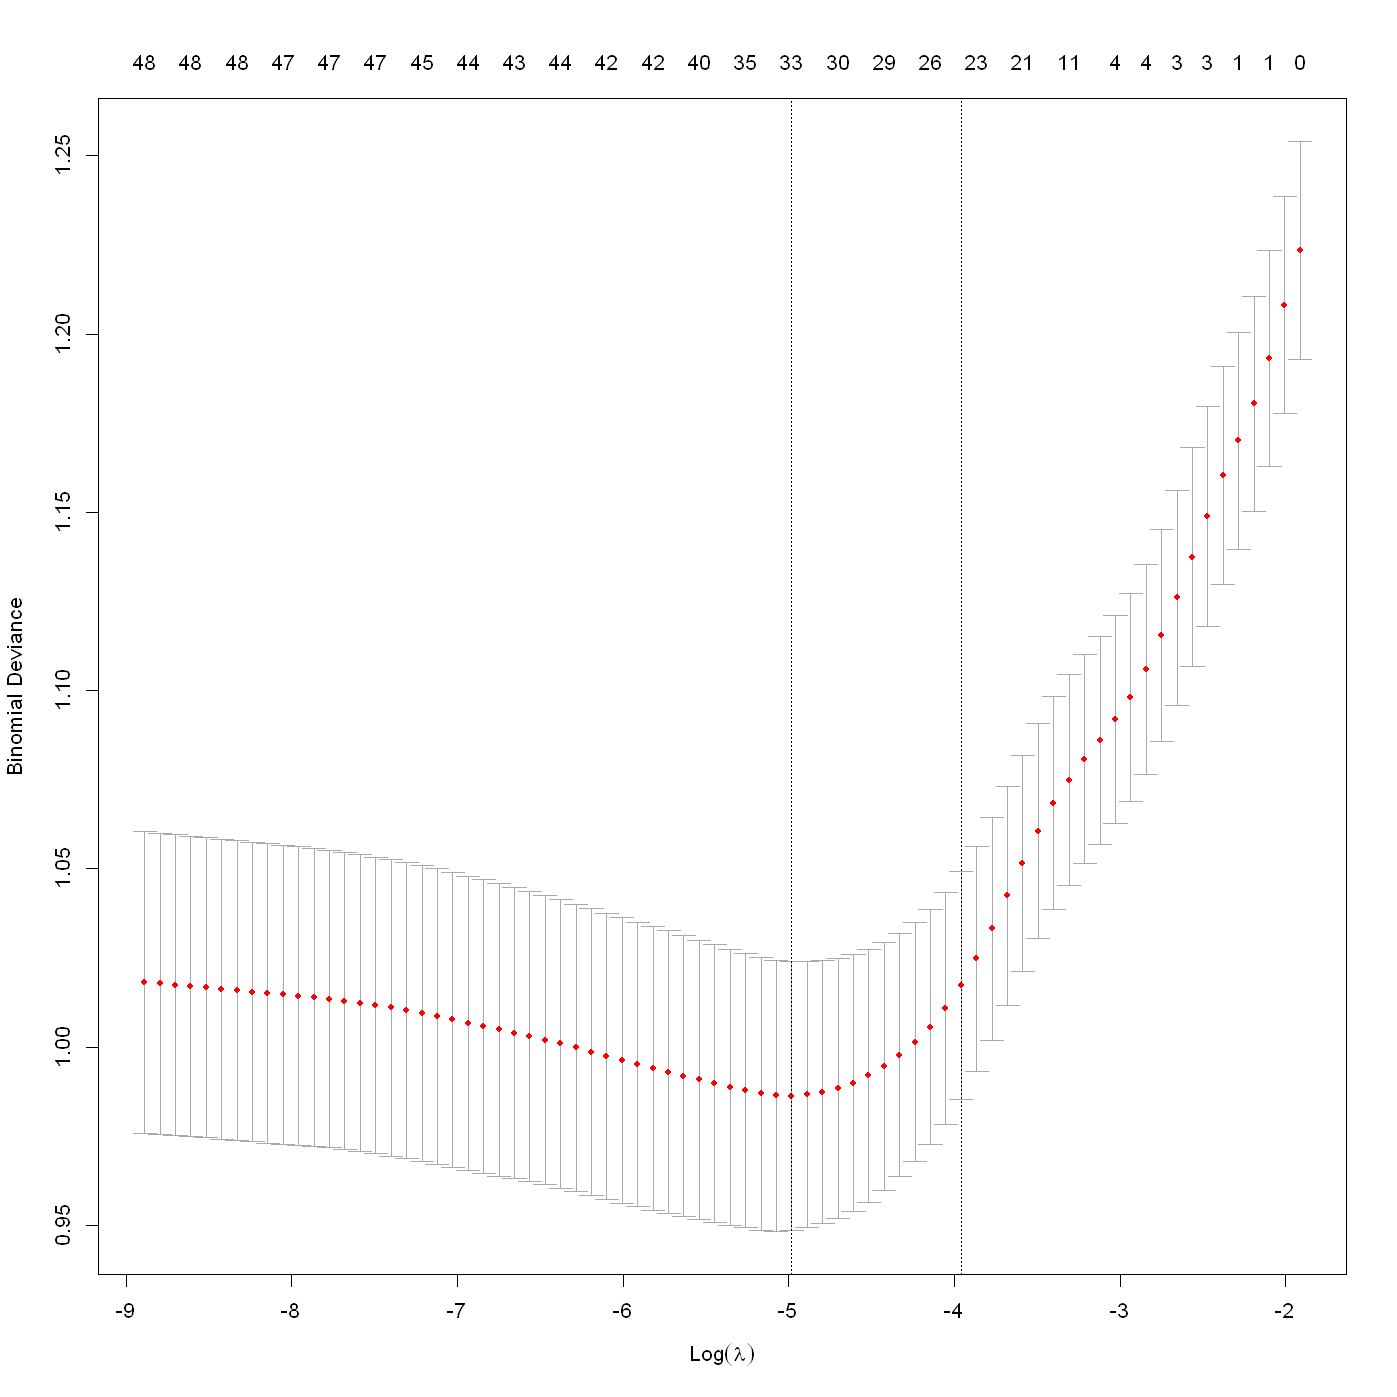

In [372]:
library(glmnet)

X_mat <- model.matrix(credibility ~ ., df)
y_mat <- df$credibility %>% as.matrix

lasso.fit <- glmnet(x=X_mat, y=y_mat, family = "binomial", alpha = 1)
cv.lasso <- cv.glmnet(x=X_mat, y=y_mat, family = "binomial", alpha = 1, nfolds = 10)
plot(cv.lasso)

In [375]:
coef(lasso.fit, s=c(cv.lasso$lambda.1se, cv.lasso$lambda.min))

50 x 2 sparse Matrix of class "dgCMatrix"
                                      1             2
(Intercept)               -1.113152e+00 -1.898256e+00
(Intercept)                .             .           
chk_acct>=200             -1.201702e-01 -3.733422e-01
chk_acctNeg                4.087132e-01  4.278162e-01
chk_acctNone              -1.058516e+00 -1.189823e+00
credit_dur                 2.480824e-02  2.596471e-02
credit_histbank_duly       3.124431e-01  5.012222e-01
credit_histcritical       -4.400419e-01 -6.573500e-01
credit_histdelays          .            -6.423887e-02
credit_histtill_now        .             .           
purposeappliances          .             .           
purposebusiness            .             .           
purposeedu                 2.501578e-01  5.464474e-01
purposefurn                .             .           
purposenew_car             3.340321e-01  5.642136e-01
purposeradio_TV           -7.639589e-02 -1.370470e-01
purposerepairs             .            

## 1.3 Select Threshold

We make use of the ROC cost code found in [this github repo](https://github.com/joyofdata/joyofdata-articles/tree/master/roc-auc) found in this [post](https://www.r-bloggers.com/2015/06/illustrated-guide-to-roc-and-auc/). With the ad hoc cost function, we find that a threshold around 0.8 is optimal.

In [355]:
calculate_roc <- function(df, cost_of_fp, cost_of_fn, n=100) {
  tpr <- function(df, threshold) {
    sum(df$pred >= threshold & df$credibility == 1) / sum(df$credibility == 1)
  }
  
  fpr <- function(df, threshold) {
    sum(df$pred >= threshold & df$credibility == 0) / sum(df$credibility == 0)
  }
  
  cost <- function(df, threshold, cost_of_fp, cost_of_fn) {
    sum(df$pred >= threshold & df$credibility == 0) * cost_of_fp + 
      sum(df$pred < threshold & df$credibility == 1) * cost_of_fn
  }
  
  roc <- data.frame(threshold = seq(0,1,length.out=n), tpr=NA, fpr=NA)
  roc$tpr <- sapply(roc$threshold, function(th) tpr(df, th))
  roc$fpr <- sapply(roc$threshold, function(th) fpr(df, th))
  roc$cost <- sapply(roc$threshold, function(th) cost(df, th, cost_of_fp, cost_of_fn))
  
  return(roc)
}

plot_roc <- function(roc, threshold, cost_of_fp, cost_of_fn) {
  library(gridExtra)
  
  norm_vec <- function(v) (v - min(v))/diff(range(v))
  
  idx_threshold = which.min(abs(roc$threshold-threshold))
  
  col_ramp <- colorRampPalette(c("green","orange","red","black"))(100)
  col_by_cost <- col_ramp[ceiling(norm_vec(roc$cost)*99)+1]
  p_cost <- ggplot(roc, aes(threshold, cost)) +
    geom_line(color=rgb(0,0,1,alpha=0.3)) +
    geom_point(color=col_by_cost, size=4, alpha=0.5) +
    labs(title = sprintf("cost function")) +
    geom_vline(xintercept=threshold, alpha=0.5, linetype="dashed")
  
  return(p_cost)
}


df$pred <- predict(logit_reg, type="response")
roc <- calculate_roc(df, 5, 1, 100)
roc %>% setDT
roc[order(cost)][1:10]

threshold,tpr,fpr,cost
<dbl>,<dbl>,<dbl>,<dbl>
0.8080808,0.14333333,0.005714286,277
0.7979798,0.14666667,0.007142857,281
0.8181818,0.11666667,0.005714286,285
0.8282828,0.11000000,0.005714286,287
0.7878788,0.15333333,0.010000000,289
0.8383838,0.10333333,0.005714286,289
0.8484848,0.08666667,0.004285714,289
0.8585859,0.07333333,0.004285714,293
0.8787879,0.05333333,0.002857143,294


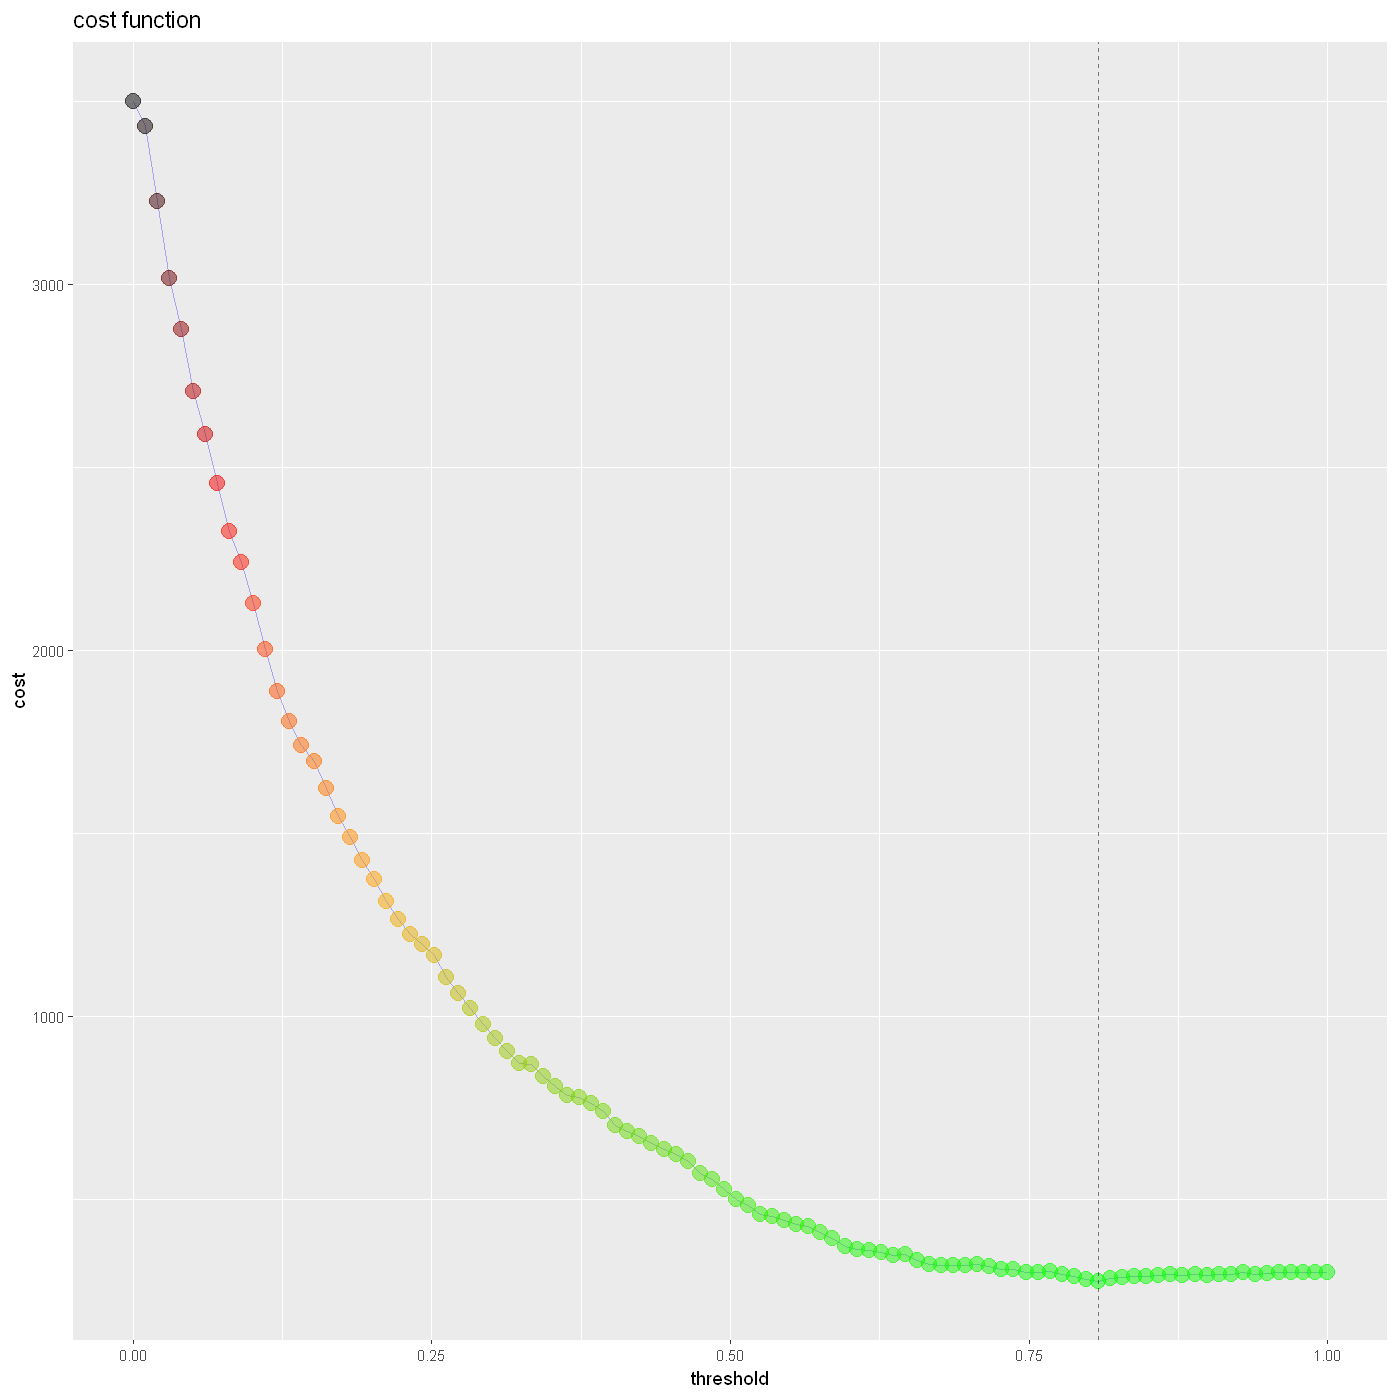

In [354]:
plot_roc(roc, roc[which.min(cost), threshold], 5, 1)